# Sales Forecasting Project
***

_**Importing the required libraries & packages**_

In [1]:
import numpy as np
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from scipy.stats import uniform, randint
import pickle
import warnings
warnings.filterwarnings('ignore')

_**Changing The Default Working Directory Path & Reading the Dataset using Pandas Command**_

In [2]:
os.chdir('C:\\Users\\Shridhar\\Desktop\\Sales Project')
df = pd.read_csv('Train.csv')

## Exploratory Data Analysis (EDA) 

_**Getting all the unique value counts from all the columns using <span style = 'background : green'> <span style = 'color : white'>  lambda   </span></span> function**_

In [3]:
df.apply(lambda x : len(x.unique()))

Item_Identifier              1559
Item_Weight                   416
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     4
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

_**Checking the dataset whether it's having duplicate values or not**_

In [4]:
df.duplicated().sum()

0

_**Checking for the null values of all the columns from the dataset**_

In [5]:
df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

_**Getting the Data types and Non-null count of all the columns from the dataset using <span style = 'background : green'><span style = 'color : white'> .info() </span> </span> statement**_

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


## Data Cleaning

_**Getting all the columns with "object" data type from the dataset and appending it to the list**_

In [7]:
cat_col = []
for x in df.dtypes.index:
    if df.dtypes[x] == 'object':
        cat_col.append(x)
display(cat_col)

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

_**Removing the columns `Item_Identifier` and `Outlet_Identifier` from the list since the both columns doesn't need any cleaning**_ 

In [8]:
cat_col.remove('Item_Identifier')
cat_col.remove('Outlet_Identifier')

_**Displaying the list after removing certain columns from it to verify**_

In [9]:
display(cat_col)

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

_**Getting the unique value counts of the columns in the list**_

In [10]:
for col in cat_col:
    print(col,len(df[col].unique()))

Item_Fat_Content 5
Item_Type 16
Outlet_Size 4
Outlet_Location_Type 3
Outlet_Type 4


_**Checking the value counts of the columns from the list and displaying it column wise**_

In [11]:
for col in cat_col:
    print(col)
    print(df[col].value_counts(),'\n')
    print('-'*55)

Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64 

-------------------------------------------------------
Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64 

-------------------------------------------------------
Outlet_Size
Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64 

-------------------------------------------------------
Outlet_Location_Type
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Loca

_**Getting the null values from the `Item_Weight` column for the null value treatment process and displaying the Dataset with null values in the `Item_Weight` column**_

In [12]:
miss_bool = df['Item_Weight'].isnull()
Item_Weight_Null = df[df['Item_Weight'].isnull()]
display(Item_Weight_Null)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
21,FDW12,NaN,Regular,0.035400,Baking Goods,144.5444,OUT027,1985,Medium,Tier 3,Supermarket Type3,4064.0432
23,FDC37,NaN,Low Fat,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876
29,FDC14,NaN,Regular,0.072222,Canned,43.6454,OUT019,1985,Small,Tier 1,Grocery Store,125.8362
...,...,...,...,...,...,...,...,...,...,...,...,...
8485,DRK37,NaN,Low Fat,0.043792,Soft Drinks,189.0530,OUT027,1985,Medium,Tier 3,Supermarket Type3,6261.8490
8487,DRG13,NaN,Low Fat,0.037006,Soft Drinks,164.7526,OUT027,1985,Medium,Tier 3,Supermarket Type3,4111.3150
8488,NCN14,NaN,Low Fat,0.091473,Others,184.6608,OUT027,1985,Medium,Tier 3,Supermarket Type3,2756.4120
8490,FDU44,NaN,Regular,0.102296,Fruits and Vegetables,162.3552,OUT019,1985,Small,Tier 1,Grocery Store,487.3656


_**Identifying the unique value counts in `Item_Identifier` column from the `Item_Weight` null value dataset**_

In [13]:
Item_Weight_Null['Item_Identifier'].value_counts()

FDK08    2
FDA08    2
FDV23    2
FDY56    2
FDI04    2
        ..
FDM44    1
FDZ48    1
FDK41    1
FDD57    1
NCN18    1
Name: Item_Identifier, Length: 1142, dtype: int64

_**Getting the mean values of the `Item_Weight` with respect to `Item_Identifier` column of the dataset using <span style = 'background : green'><span style = 'color : white'> Pivot Table </span> </span> function**_

In [14]:
Item_Weight_Mean = df.pivot_table(values = 'Item_Weight', index = 'Item_Identifier')
display(Item_Weight_Mean)

,Item_Weight
Item_Identifier,
DRA12,11.600
DRA24,19.350
DRA59,8.270
DRB01,7.390
DRB13,6.115
...,...
NCZ30,6.590
NCZ41,19.850
NCZ42,10.500


_**Treating the missing values of the `Item_Weight` column with the mean values we got above using <span style = 'background : green'><span style = 'color : white'> Pivot Table </span> </span> function and filling it out with respect to `Item_Identifier` column**_

In [15]:
for i, item in enumerate(df['Item_Identifier']):
    if miss_bool[i]:
        if item in Item_Weight_Mean:
            df['Item_Weight'][i] = Item_Weight_Mean.loc[item]['Item_Weight']
        else:
            df['Item_Weight'][i] = np.mean(df['Item_Weight'])

_**After treating the null values in the `Item_Weight` column, checking for the null value in the column**_

In [16]:
df['Item_Weight'].isna().sum()

0

_**Getting the unique value counts from `Outlet_Size` column from the dataset**_

In [17]:
df['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

_**Checking out for the null value counts from the `Outlet_Size` column from the dataset**_

In [18]:
df['Outlet_Size'].isnull().sum()

2410

_**Getting the null values from the `Outlet_Size` column for the null value treatment process and displaying the Dataset with null values in the `Outlet_Size` column**_

In [19]:
Outlet_Size_Null = df[df['Outlet_Size'].isna()]
display(Outlet_Size_Null)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350
25,NCD06,13.000,Low Fat,0.099887,Household,45.9060,OUT017,2007,NaN,Tier 2,Supermarket Type1,838.9080
28,FDE51,5.925,Regular,0.161467,Dairy,45.5086,OUT010,1998,NaN,Tier 3,Grocery Store,178.4344
...,...,...,...,...,...,...,...,...,...,...,...,...
8502,NCH43,8.420,Low Fat,0.070712,Household,216.4192,OUT045,2002,NaN,Tier 2,Supermarket Type1,3020.0688
8508,FDW31,11.350,Regular,0.043246,Fruits and Vegetables,199.4742,OUT045,2002,NaN,Tier 2,Supermarket Type1,2587.9646
8509,FDG45,8.100,Low Fat,0.214306,Fruits and Vegetables,213.9902,OUT010,1998,NaN,Tier 3,Grocery Store,424.7804
8514,FDA01,15.000,Regular,0.054489,Canned,57.5904,OUT045,2002,NaN,Tier 2,Supermarket Type1,468.7232


_**Getting the value counts of `Outlet_Type` from the `Outlet_Size` null dataset**_

In [20]:
Outlet_Size_Null['Outlet_Type'].value_counts()

Supermarket Type1    1855
Grocery Store         555
Name: Outlet_Type, dtype: int64

_**Grouping by `Outlet_Type` and `Outlet_Size` with the aggregate function of size of the `Outlet_Type` column values**_

In [21]:
df.groupby(['Outlet_Type','Outlet_Size']).agg({'Outlet_Type':[np.size]})

Outlet_Type
                                     size
Outlet_Type       Outlet_Size            
Grocery Store     Small               528
Supermarket Type1 High                932
                  Medium              930
                  Small              1860
Supermarket Type2 Medium              928
Supermarket Type3 Medium              935

_**Getting the mode values of the `Outlet_Size` with respect to `Outlet_Type` column of the dataset using <span style = 'background : green'><span style = 'color : white'> Pivot Table </span> </span> function**_ 

In [22]:
Outlet_Size_Mode = df.pivot_table(values = 'Outlet_Size', columns = 'Outlet_Type', aggfunc = (lambda x : x.mode()[0]))
display(Outlet_Size_Mode)

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


_**Getting the null values of `Outlet_Size` column from the dataset and treating the null value using mode values of the `Outlet_Size` with respect to `Outlet_Type` column**_

In [23]:
miss_bool = df['Outlet_Size'].isna()
df.loc[miss_bool,'Outlet_Size'] = df.loc[miss_bool,'Outlet_Type'].apply(lambda x : Outlet_Size_Mode[x])

_**After missing value treatment of the `Outlet_Size` column, checking for the null values in the column**_

In [24]:
df['Outlet_Size'].isna().sum()

0

_**Checking for the null values of all the columns from the dataset after missing value treatment**_

In [25]:
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

_**Getting the count of `Item_Visibility` column with value 0**_

In [26]:
sum(df['Item_Visibility'] == 0)

526

_**Filling out the 0 values from the `Item_Visibility` column with mean values using <span style = 'background : green'><span style = 'color : white'> replace </span> </span> function**_ 

In [27]:
df.loc[:,'Item_Visibility'].replace([0],[df['Item_Visibility'].mean()],inplace = True)

_**Now, again checking out for 0 values in the `Item_Visibility` column after filling it out to verify any misplacement happened**_

In [28]:
sum(df['Item_Visibility'] == 0)

0

_**Getting the unique value counts from the `Item_Fat_Content` column**_

In [29]:
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

_**After seeing the unique value counts from the `Item_Fat_Content` column, there have been some mistyping occured like the same categories were typed under different names. For further processing, all the mistypings are corrected and named under a single category. Checking out for the value counts of `Item_Fat_Content` column**_

In [30]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF' : 'Low Fat', 'low fat' : 'Low Fat', 'reg' : 'Regular'})
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

_**Adding new column `New_Item_Type` to the dataset by getting the first two characters from the `Item_Identifier` column which represents the category of the item and getting the value counts of the `New_Item_Type` column**_

In [31]:
df['New_Item_Type'] = df['Item_Identifier'].apply(lambda x : x[:2])
df['New_Item_Type'].value_counts()

FD    6125
NC    1599
DR     799
Name: New_Item_Type, dtype: int64

_**As the `New_Item_Type` column has values which is subjected to categories for better understanding, replacing the codes with meaningful categorical item name and getting the value counts of `New_Item_Type` column**_

In [32]:
df['New_Item_Type'] = df['New_Item_Type'].replace({'FD' : 'Food', 'NC' : 'Non-Consumables', 'DR' : 'Drinks'})
df['New_Item_Type'].value_counts()

Food               6125
Non-Consumables    1599
Drinks              799
Name: New_Item_Type, dtype: int64

_**Grouping by `New_Item_Type` and `Item_Fat_Content` with the aggregate function of size of the `Outlet_Type` column values**_

In [33]:
df.groupby(['New_Item_Type','Item_Fat_Content']).agg({'Outlet_Type':[np.size]})

Outlet_Type
                                        size
New_Item_Type   Item_Fat_Content            
Drinks          Low Fat                  728
                Regular                   71
Food            Low Fat                 3190
                Regular                 2935
Non-Consumables Low Fat                 1599

_**From the above output its clear that Non-Consumable type from `New_Item_Type` column is mapped to Low Fat category in `Item_Fat_Content` column. So marking it as Non-Edible in `Item_Fat_Content` column**_

In [34]:
df.loc[df['New_Item_Type'] == 'Non-Consumables','Item_Fat_Content'] = 'Non-Edible'
df['Item_Fat_Content'].value_counts()

Low Fat       3918
Regular       3006
Non-Edible    1599
Name: Item_Fat_Content, dtype: int64

_**Getting all the unique value from `Outlet_Establishment_Year` column from the dataset**_

In [35]:
df['Outlet_Establishment_Year'].unique()

array([1999, 2009, 1998, 1987, 1985, 2002, 2007, 1997, 2004], dtype=int64)

_**The `Outlet_Establishment_Year` column from the dataset has no significance on its own so calculating the years of outlet established until this year and adding it as `Outlet_Years` column to the dataset**_

In [36]:
curr_time = datetime.datetime.now()
df['Outlet_Years'] = df['Outlet_Establishment_Year'].apply(lambda x: curr_time.year - x)

## Data Visualization

_**Plotting the Bar Graph with count of `Item_Fat_Content`  and confirm that there are no null values and identify all unique values from the `Item_Fat_Content` and saving the PNG File**_

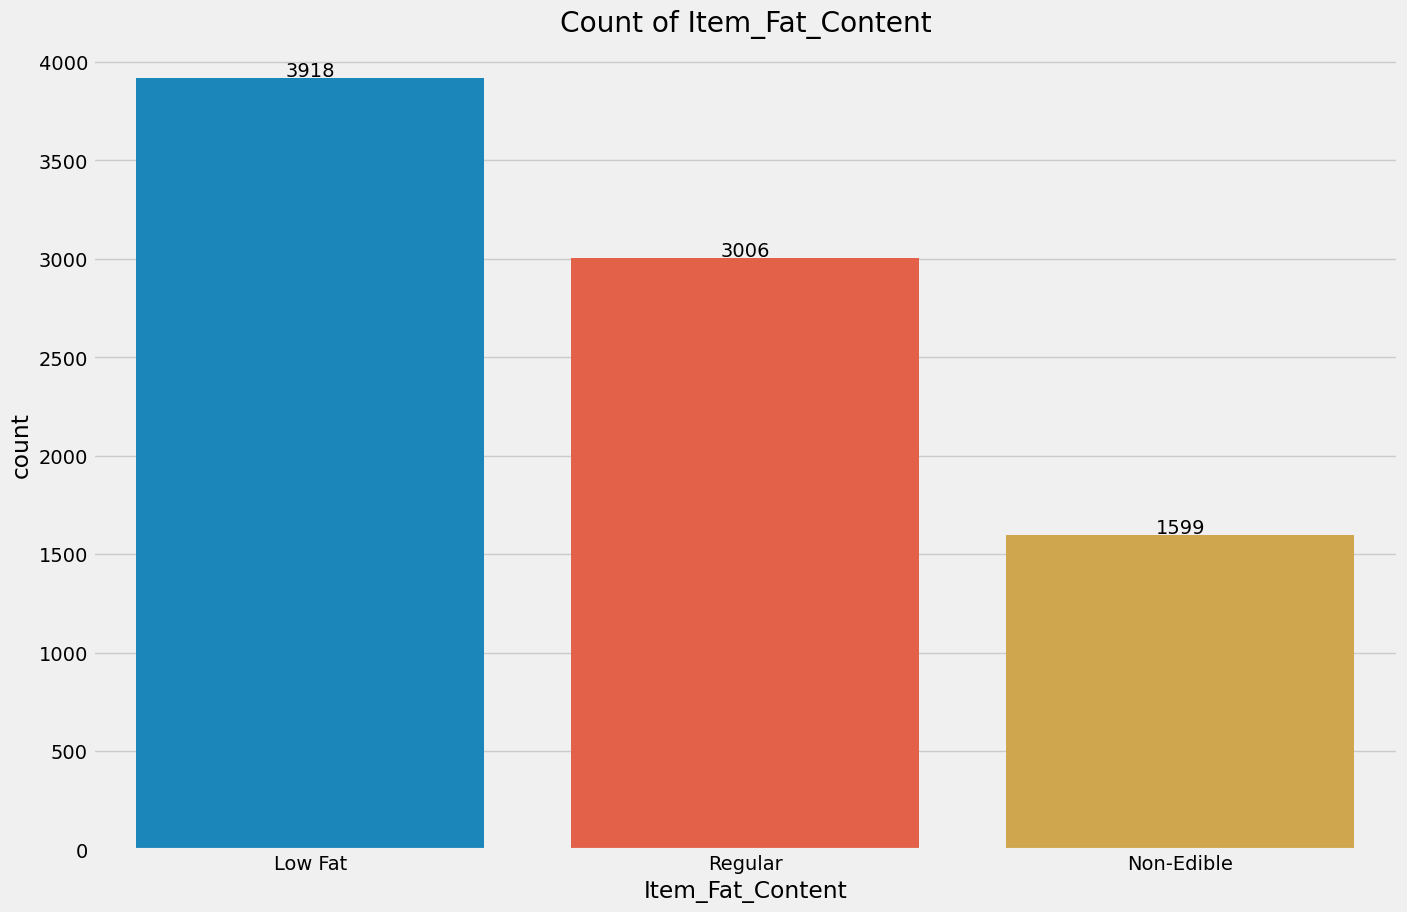

In [37]:
plt.rcParams['figure.figsize'] = 15,10
plt.style.use('fivethirtyeight')
plot = sns.countplot(x = df['Item_Fat_Content'])
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2.0,p.get_height()),
                 ha = 'center',va = 'center',xytext = (0,5),textcoords = 'offset points')
plt.title('Count of Item_Fat_Content')
plt.savefig('Count of Item_Fat_Content.png')
plt.show()

_**Plotting the Bar Graph with count of `Item_Type`  and confirm that there are no null values and identify all unique values from the `Item_Type` and saving the PNG File**_

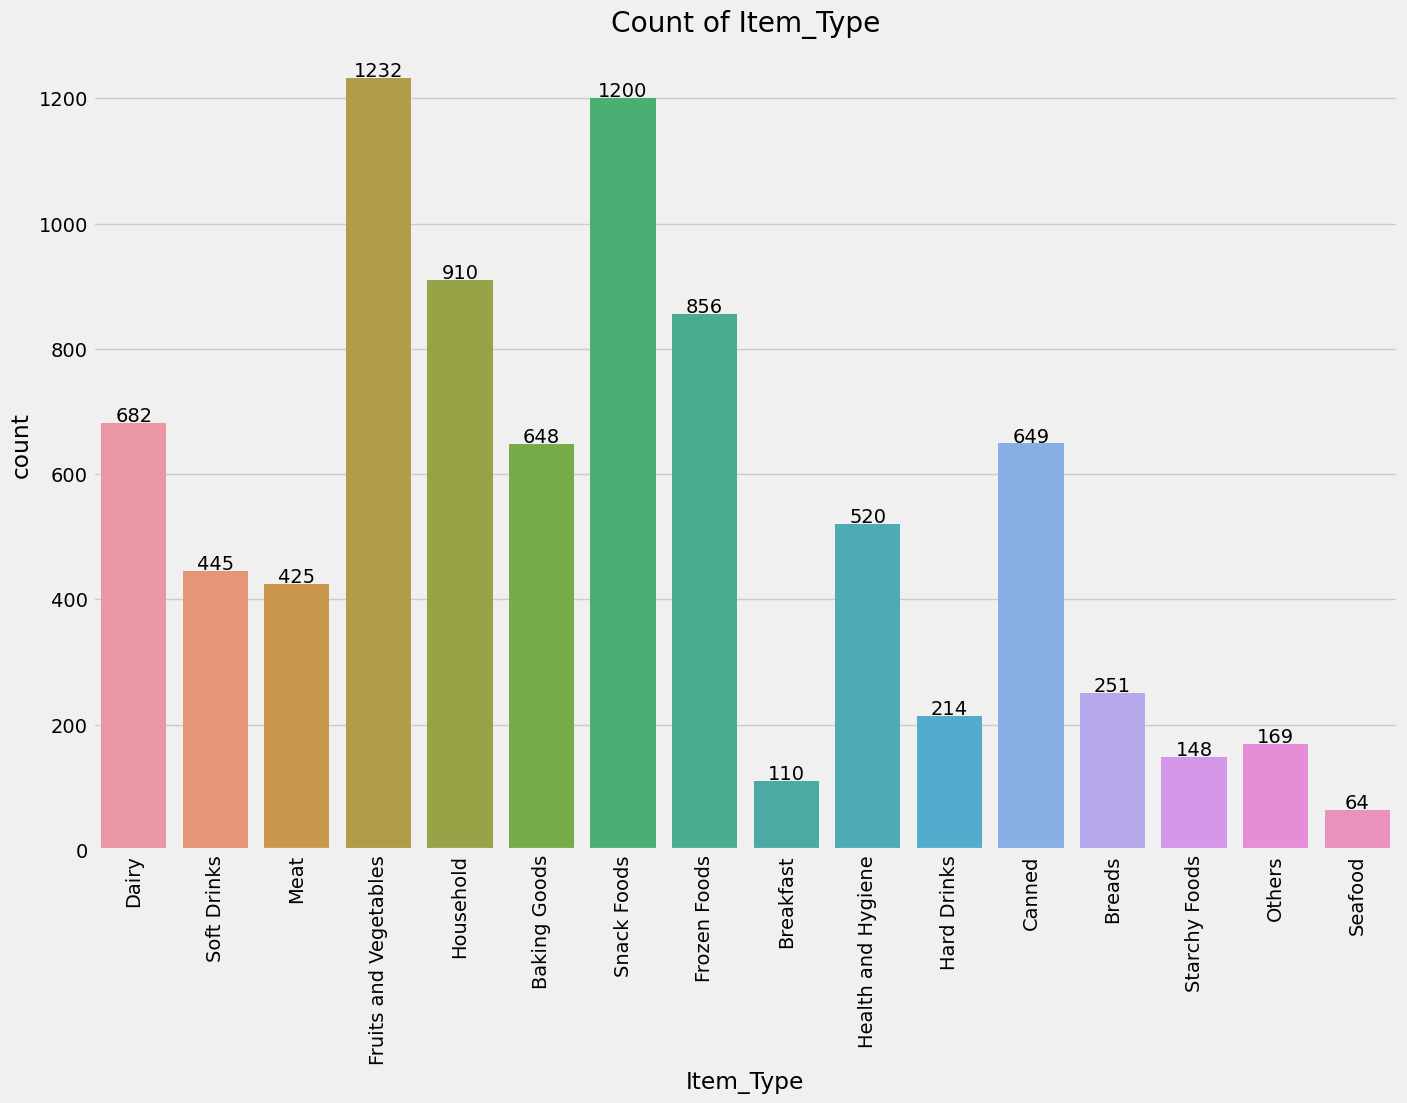

In [38]:
plot = sns.countplot(x = df['Item_Type'])
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2.0,p.get_height()),
                 ha = 'center',va = 'center',xytext = (0,5),textcoords = 'offset points')
plt.xticks(rotation = 90)
plt.title('Count of Item_Type')
plt.savefig('Count of Item_Type.png')
plt.show()

_**Plotting the Bar Graph with count of `Outlet_Establishment_Year`  and confirm that there are no null values and identify all unique values from the `Outlet_Establishment_Year` and saving the PNG File**_

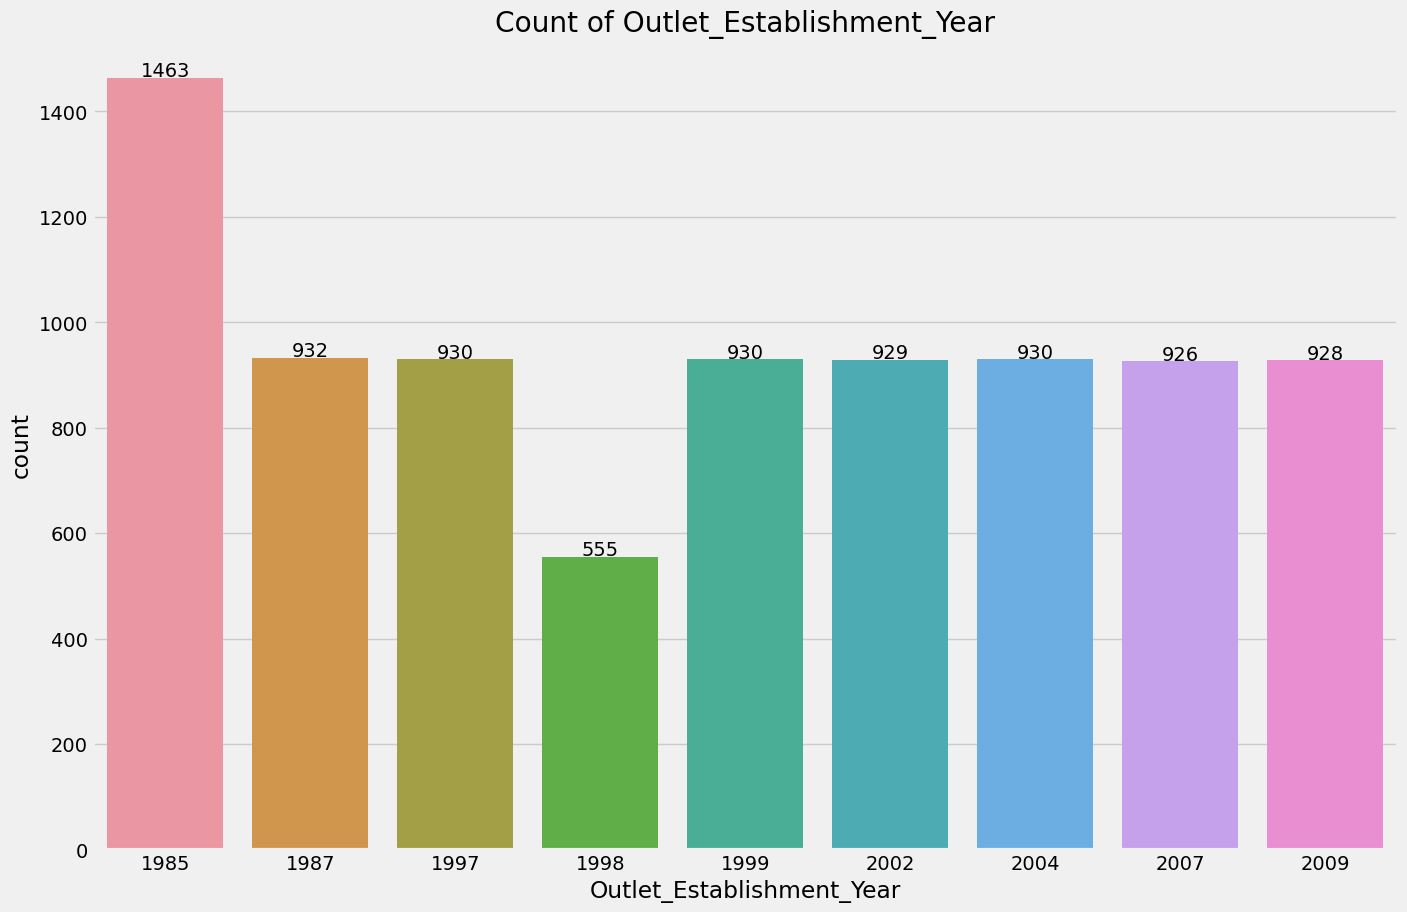

In [39]:
plot = sns.countplot(x = df['Outlet_Establishment_Year'])
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2.0,p.get_height()),
                 ha = 'center',va = 'center',xytext = (0,5),textcoords = 'offset points')
plt.title('Count of Outlet_Establishment_Year')
plt.savefig('Count of Outlet_Establishment_Year.png')
plt.show()

_**Plotting the Bar Graph with count of `Outlet_Location_Type`  and confirm that there are no null values and identify all unique values from the `Outlet_Location_Type` and saving the PNG File**_

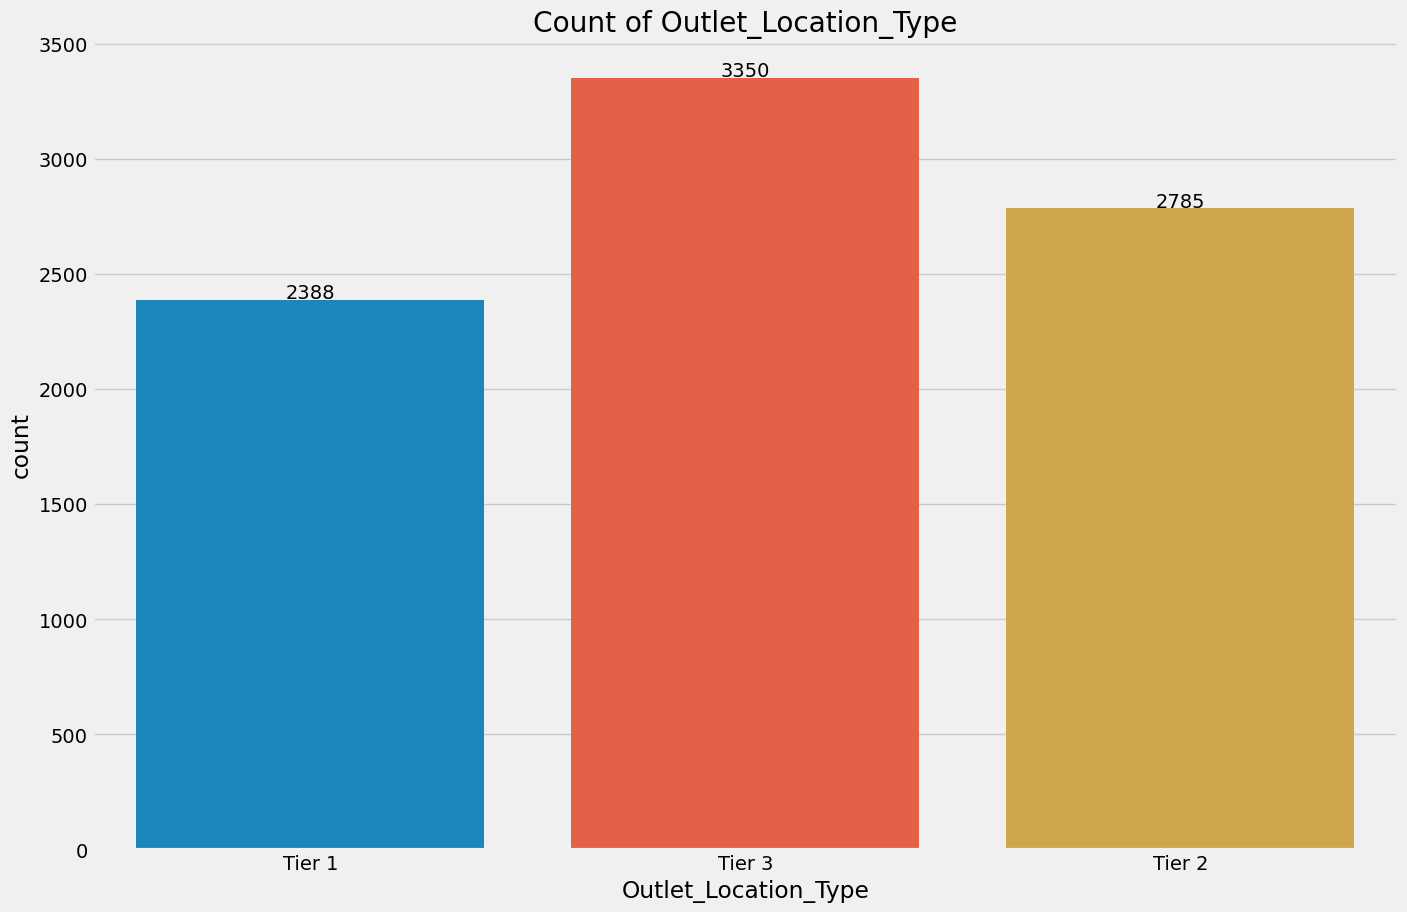

In [40]:
plot = sns.countplot(x = df['Outlet_Location_Type'])
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2.0,p.get_height()),
                 ha = 'center',va = 'center',xytext = (0,5),textcoords = 'offset points')
plt.title('Count of Outlet_Location_Type')
plt.savefig('Count of Outlet_Location_Type.png')
plt.show()

_**Plotting the Bar Graph with count of `Outlet_Size`  and confirm that there are no null values and identify all unique values from the `Outlet_Size` and saving the PNG File**_

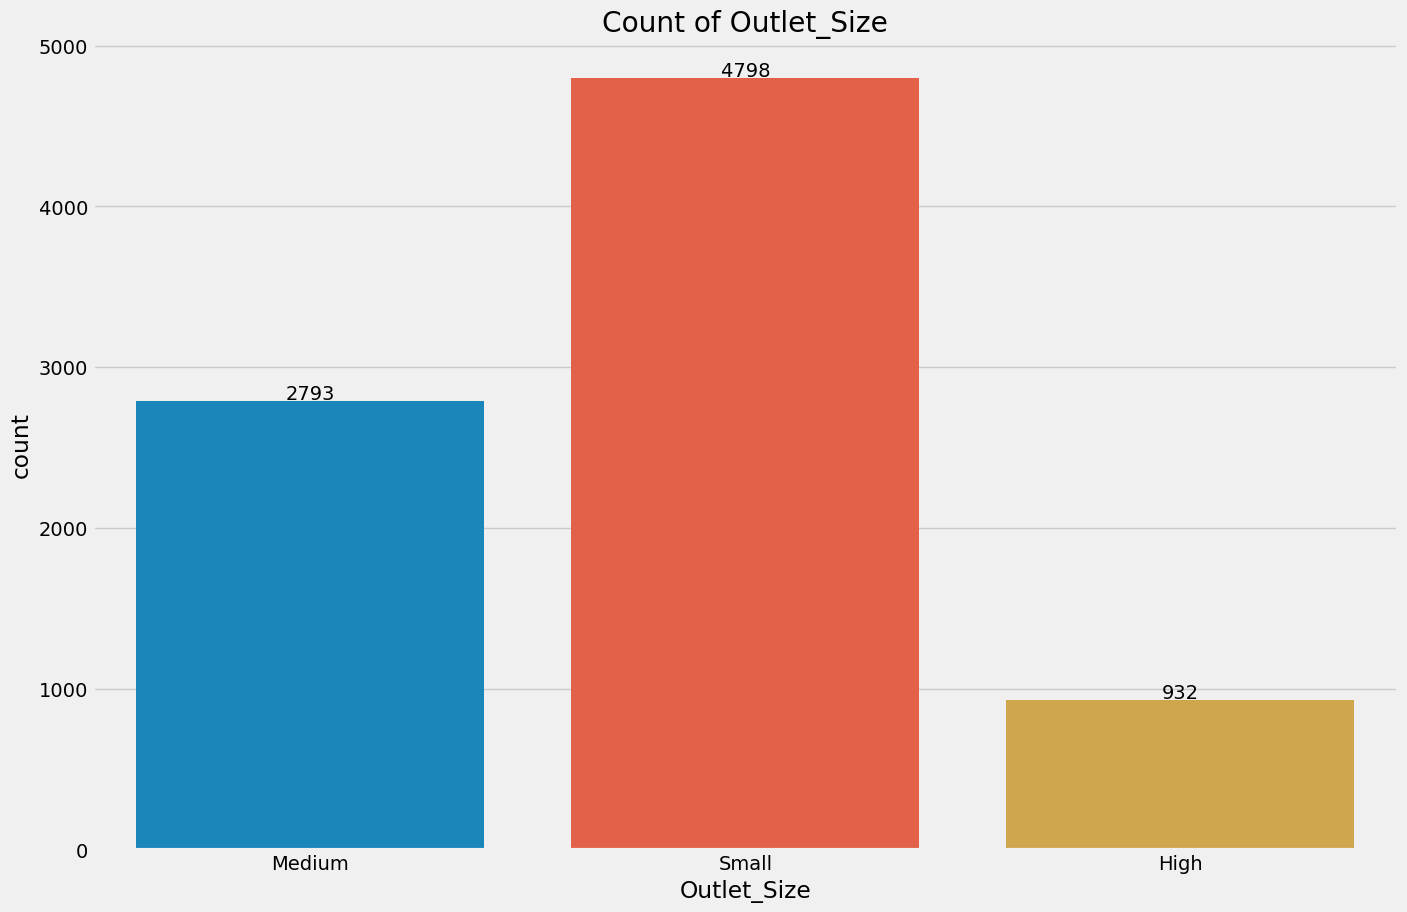

In [41]:
plot = sns.countplot(x = df['Outlet_Size'])
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2.0,p.get_height()),
                 ha = 'center',va = 'center',xytext = (0,5),textcoords = 'offset points')
plt.title('Count of Outlet_Size')
plt.savefig('Count of Outlet_Size.png')
plt.show()

_**Plotting the Bar Graph with count of `Outlet_Type`  and confirm that there are no null values and identify all unique values from the `Outlet_Type` and saving the PNG File**_

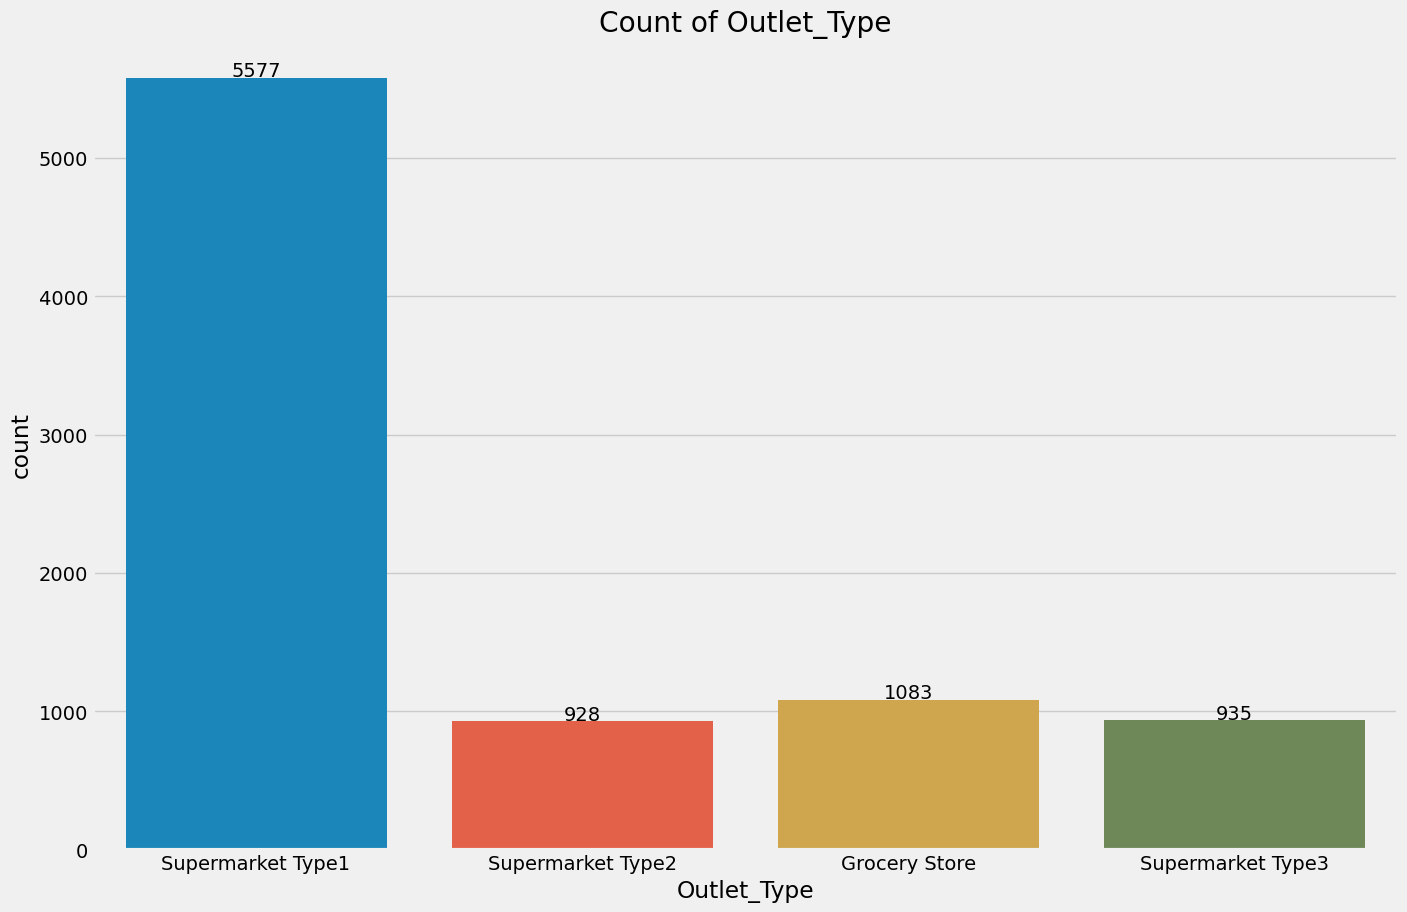

In [42]:
plot = sns.countplot(x = df['Outlet_Type'])
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2.0,p.get_height()),
                 ha = 'center',va = 'center',xytext = (0,5),textcoords = 'offset points')
plt.title('Count of Outlet_Type')
plt.savefig('Count of Outlet_Type.png')
plt.show()

_**Visualizing the data distribution of the `Item_weight` column against the density distribution using Seaborn Distplot and saving the PNG file**_

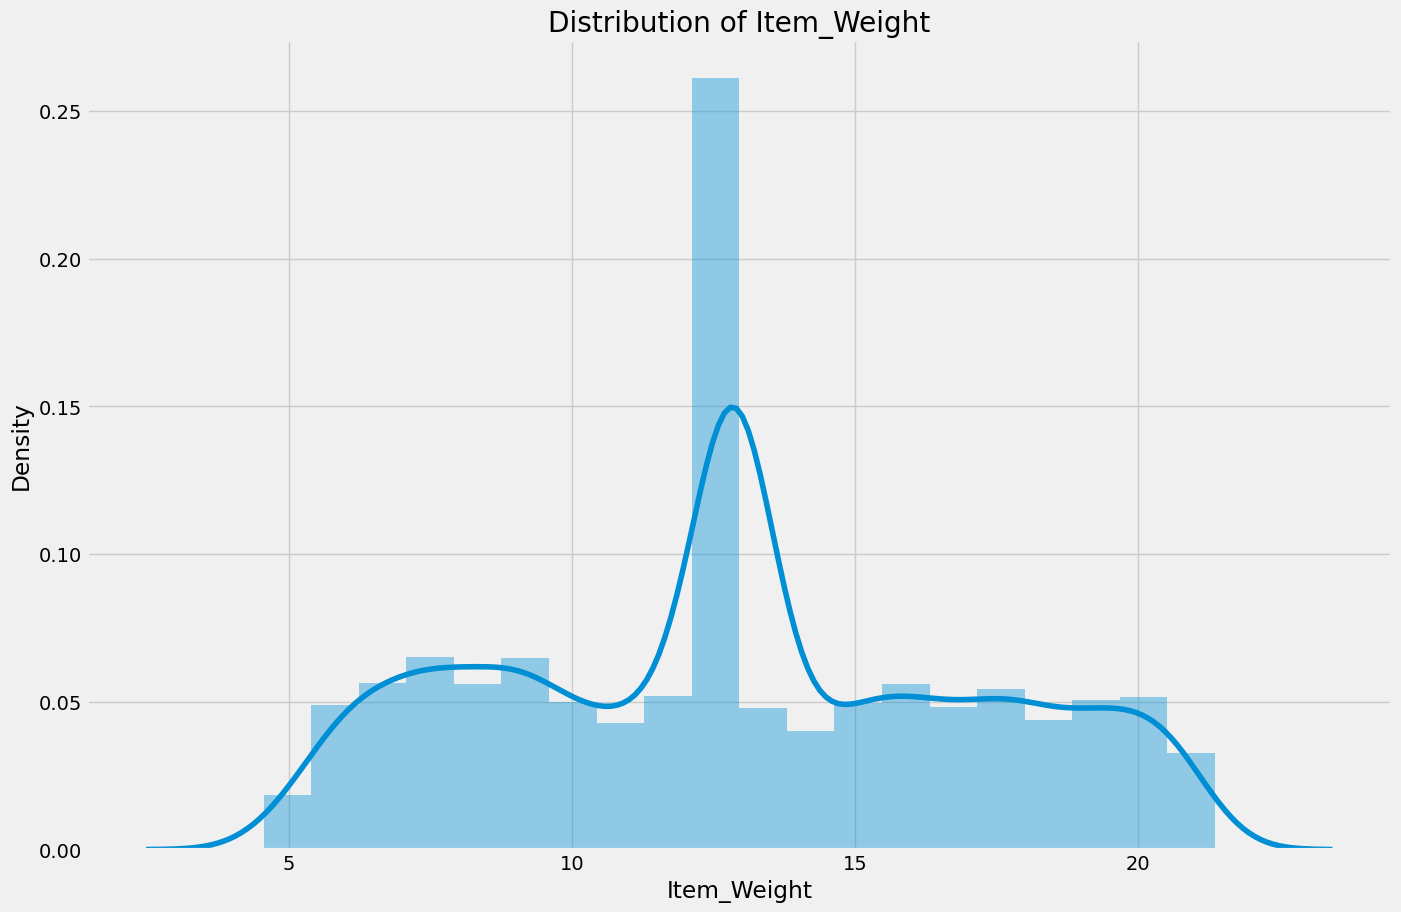

In [43]:
sns.distplot(df['Item_Weight'],bins = 20)
plt.title('Distribution of Item_Weight')
plt.savefig('Distribution of Item_Weight.png')
plt.show()

_**Getting the Correlation Values from all the numeric columns from the dataset using Seaborn Heatmap & saving the PNG File**_

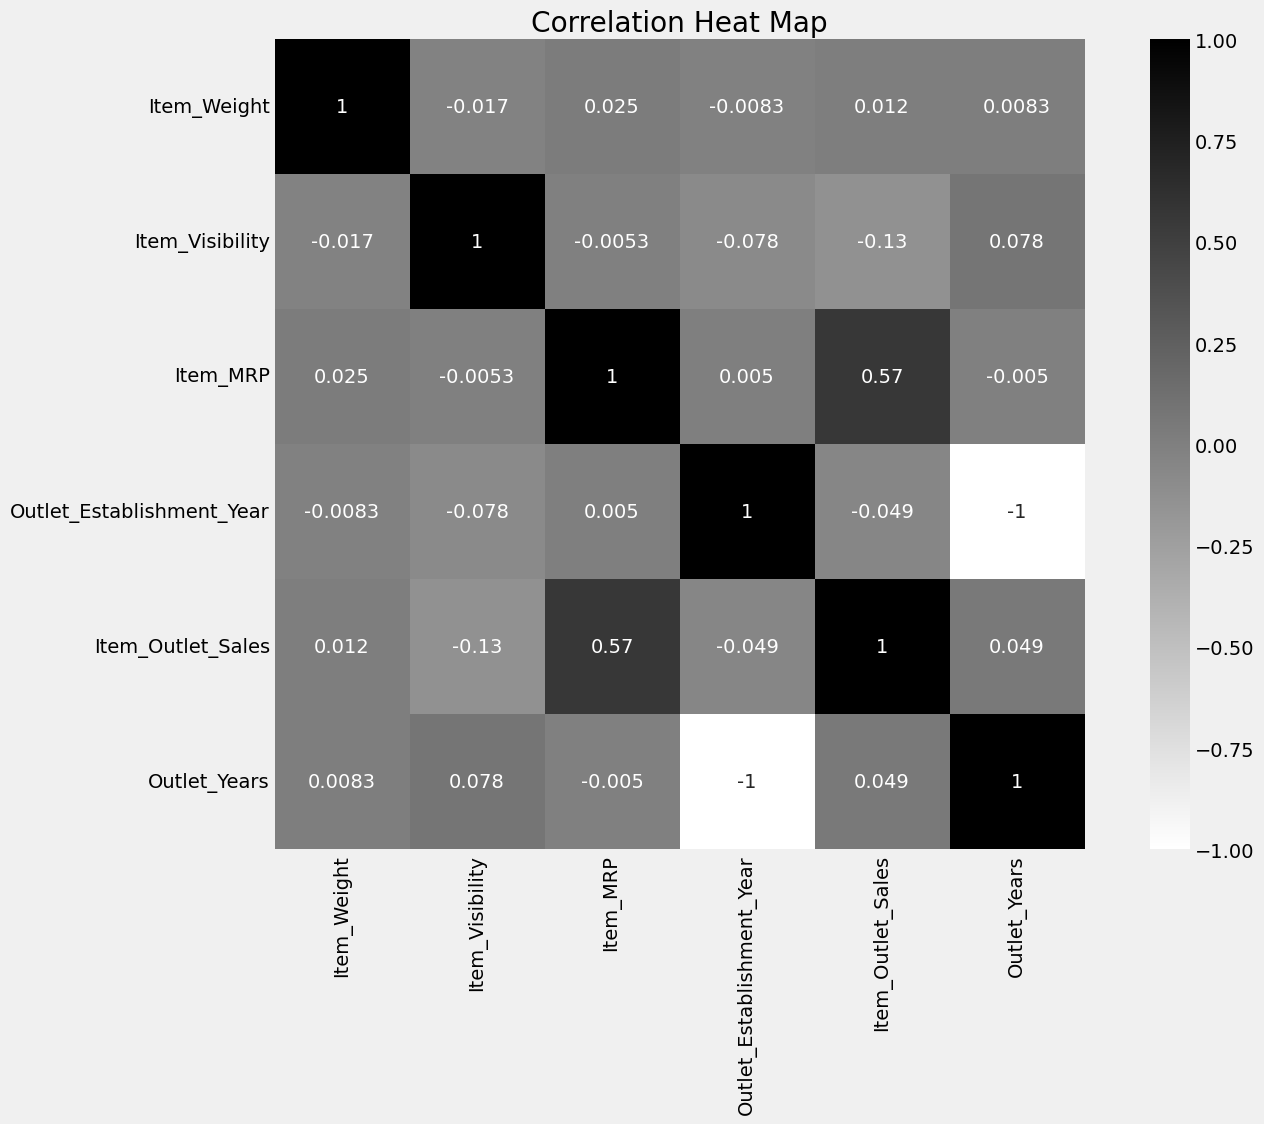

In [44]:
sns.heatmap(df.corr(),cmap = 'binary', cbar = True, annot = True, square = True)
plt.title('Correlation Heat Map')
plt.savefig('Correlation Heat Map.png')
plt.show()

## Data Preprocessing

_**Label Encoding the `Outlet_Identifier` column and adding it as a new column `Outlet` to the dataset**_

In [45]:
le = LabelEncoder()
df['Outlet'] = le.fit_transform(df['Outlet_Identifier'])

_**Getting the data types of all the columns to find out the "object" data types columns for preprocessing before assigning it to dependent variable and independent variable**_

In [46]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
New_Item_Type                 object
Outlet_Years                   int64
Outlet                         int32
dtype: object

_**Adding all the necessary column with "object" data types to the list and Label Encoding the columns**_

In [47]:
cat_col = ['Item_Fat_Content','Item_Type','Outlet_Size','Outlet_Location_Type','Outlet_Type','New_Item_Type']
for col in cat_col:
    df[col] = le.fit_transform(df[col])

_**One Hot Encoding the columns `Item_Fat_Content`,`Outlet_Size`,`Outlet_Location_Type`,`Outlet_Type`,`New_Item_Type` using  <span style = 'background : green'><span style = 'color : white'> get dummies </span> </span> function**_ 

In [48]:
df = pd.get_dummies(df,columns = ['Item_Fat_Content','Outlet_Size','Outlet_Location_Type','Outlet_Type','New_Item_Type'])

_**Assigning the dependent and independent variable**_

In [49]:
x = df.drop(['Item_Identifier','Outlet_Identifier','Outlet_Establishment_Year','Item_Outlet_Sales'],axis=1)
y=df['Item_Outlet_Sales']

## Model Fitting

_**Splitting the dependent variable & independent variable into training and test dataset using  <span style = 'background : green'><span style = 'color : white'> train test split </span> </span>**_

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 10)

_**Defining the function for the ML algorithm and fitting it with the passing dependent and independent variable, predicting the dependent variable using algorithm with independent variable. With using  <span style = 'background : green'><span style = 'color : white'> cross val score [Cross Validation] </span> </span> process getting the Model Report with cv_score using "neg_mean_squared_error" as scoring and also getting the absolute average mean of cv_score. After that using  <span style = 'background : green'><span style = 'color : white'> cross val score [Cross Validation] </span> </span> process, getting the cv_score as R2 score using default scoring parameter and also again getting the mean value of cv_score with default scoring as Average R2 score. End of the function the Accuracy for full data is actually determined using  actual R2 score founded between the dependent variable and predicted dependent variable. Atlast getting the coefficient of algorithm with all the columns and plotting the graph using coefficient value of algorithm to show impact of the each column**_

In [51]:
def train(model, x, y):
    model.fit(x, y)
    pred = model.predict(x)
    cv_score = cross_val_score(model,x,y,scoring = 'neg_mean_squared_error', cv = 10)
    print('Model Report : \n')
    print('Scoring - neg_mean_squared_error')
    print(cv_score,'\n')
    cv_score = np.abs(np.mean(cv_score))
    print('Absolute Average of neg_mean_squared_error : ',cv_score)
    cv_score = cross_val_score(model, x, y, cv = 10)
    print()
    print('R2 Score')
    print(cv_score,'\n')
    cv_score = np.mean(cv_score)
    print('Average R2 Score : ',cv_score,'\n')
    print('Accuracy for Full Data :')
    print('R2 Score : ',r2_score(y,pred),'\n')
    coef = pd.Series(model.coef_, x.columns).sort_values()
    print (coef)
    coef.plot(kind='bar', title="Model Coefficients")
    plt.show()

_**Fitting the <span style ='color:green'> Linear Regression </span> algorithm to the model and passing it to the defined function with train dependent and train independent variable and getting the output for the defined function**_

Model Report : 

Scoring - neg_mean_squared_error
[-1308363.54107399 -1317107.74968154 -1282733.888695   -1368507.72391364
 -1195693.21293122 -1314995.99930038 -1224984.24333567 -1371452.26391224
 -1138875.63213369 -1309200.11182761] 

Absolute Average of neg_mean_squared_error :  1283191.4366804995

R2 Score
[0.54291572 0.54630942 0.57755002 0.57652092 0.62639187 0.51661562
 0.57357095 0.50602569 0.57904273 0.52933781] 

Average R2 Score :  0.5574280748499401 

Accuracy for Full Data :
R2 Score :  0.5625380588222987 

Outlet_Type_1            -1545.096518
Outlet_Size_1            -1143.870920
Outlet_Location_Type_2    -910.945639
Outlet_Type_2             -883.280776
Outlet_Size_2             -671.685443
Outlet_Type_0             -536.493175
Item_Visibility           -192.479994
Outlet_Years              -188.339775
New_Item_Type_0            -31.688628
New_Item_Type_2            -23.894275
Item_Fat_Content_1         -23.894275
Item_Type                    0.020929
Item_Weight        

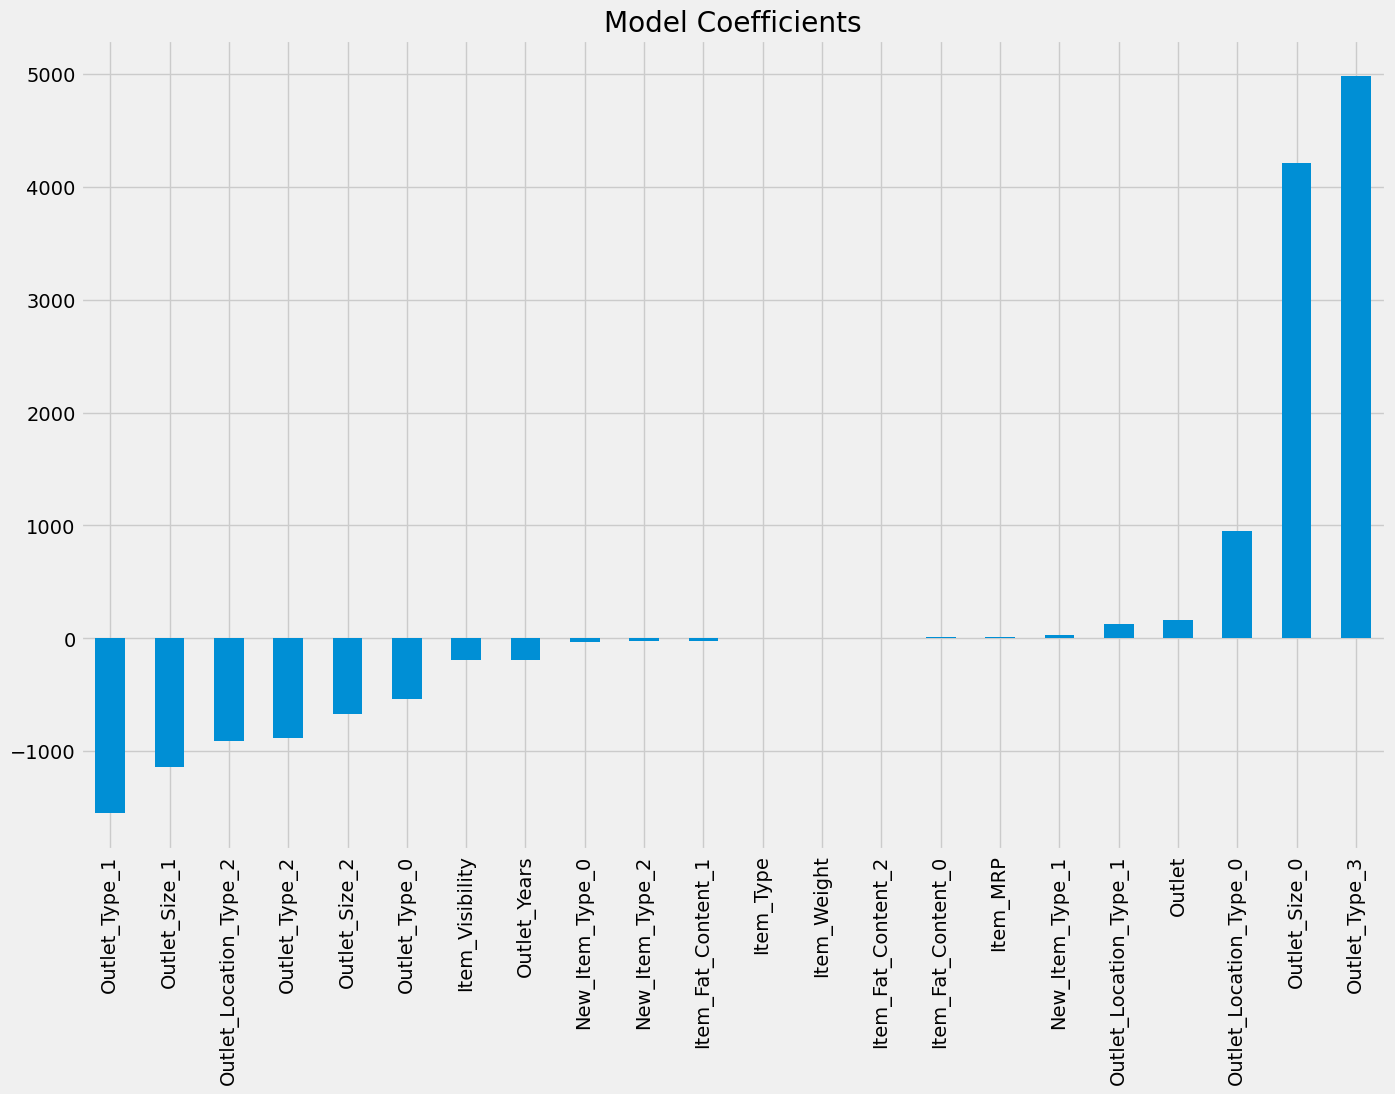

In [52]:
model = LinearRegression(normalize = True)
train(model,x_train,y_train)

_**Fitting the <span style ='color:green'> Ridge </span> algorithm to the model and passing it to the defined function with train dependent and train independent variable and getting the output for the defined function**_

Model Report : 

Scoring - neg_mean_squared_error
[-1634366.79435002 -1659312.01248731 -1635399.05212848 -1831459.60361034
 -1710244.25782122 -1541858.82626585 -1578752.10468889 -1639627.12413278
 -1438709.56572747 -1635590.66754369] 

Absolute Average of neg_mean_squared_error :  1630532.0008756046

R2 Score
[0.42902462 0.42843383 0.46140481 0.43326237 0.46561446 0.43322225
 0.45042088 0.40943356 0.46821652 0.41199922] 

Average R2 Score :  0.4391032527776444 

Accuracy for Full Data :
R2 Score :  0.4415560070416681 

Item_Visibility          -993.202665
Outlet_Type_0            -794.162625
Outlet_Location_Type_0   -174.734308
Outlet_Size_2            -163.930878
Outlet_Type_2            -124.821603
New_Item_Type_0           -52.378570
New_Item_Type_2           -19.838513
Item_Fat_Content_1        -19.838513
Item_Weight                 2.278801
Item_Type                   2.352996
Outlet_Years                3.662567
Item_Fat_Content_0          4.397866
Outlet_Size_0               6.1

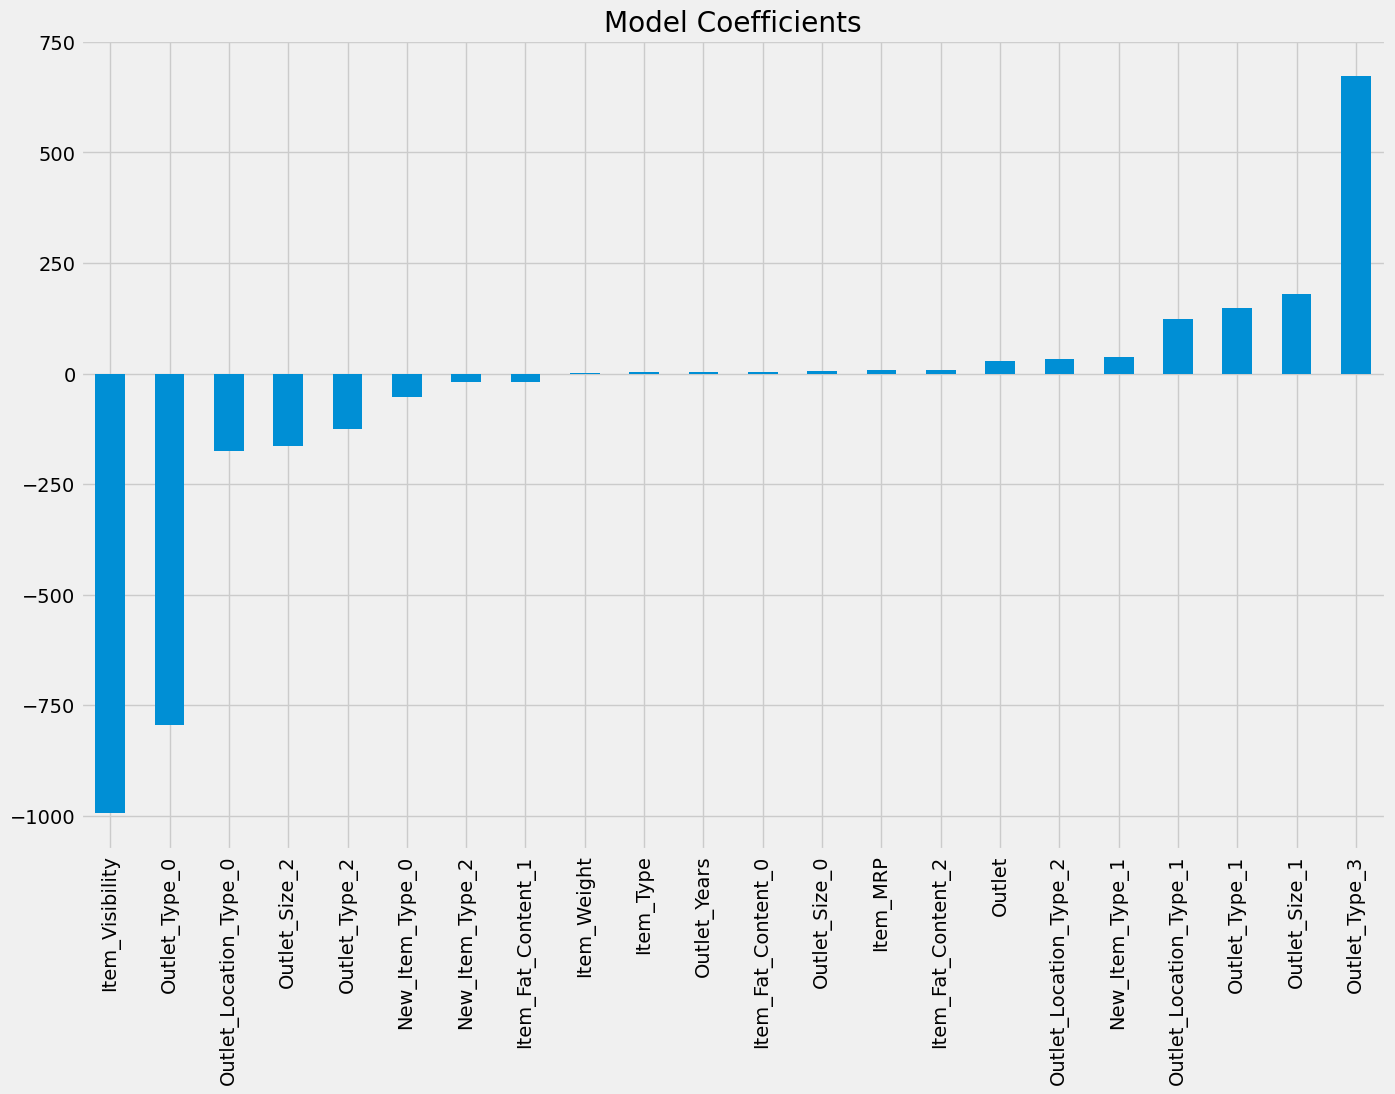

In [53]:
model = Ridge(normalize = True)
train(model, x_train, y_train)

_**Fitting the <span style ='color:green'> Lasso </span> algorithm to the model and passing it to the defined function with train dependent and train independent variable and getting the output for the defined function**_

Model Report : 

Scoring - neg_mean_squared_error
[-1302218.36653497 -1332170.89643348 -1294820.35958161 -1413201.58434458
 -1245573.13435591 -1302305.8412564  -1256224.54154128 -1381979.27138655
 -1150748.76766032 -1331497.70024599] 

Absolute Average of neg_mean_squared_error :  1301074.046334107

R2 Score
[0.54506257 0.54112077 0.57356951 0.56269059 0.61080631 0.52128045
 0.56269589 0.50223404 0.57465412 0.52132175] 

Average R2 Score :  0.5515435999738486 

Accuracy for Full Data :
R2 Score :  0.5530471652098432 

Outlet_Type_0            -1734.758186
Item_Weight                  0.000000
New_Item_Type_0             -0.000000
Outlet_Type_2               -0.000000
Outlet_Type_1                0.000000
Outlet_Location_Type_2      -0.000000
Outlet_Location_Type_1       0.000000
Outlet_Location_Type_0      -0.000000
Outlet_Size_2               -0.000000
New_Item_Type_1              0.000000
Outlet_Size_1                0.000000
Item_Fat_Content_2           0.000000
Item_Fat_Content_1  

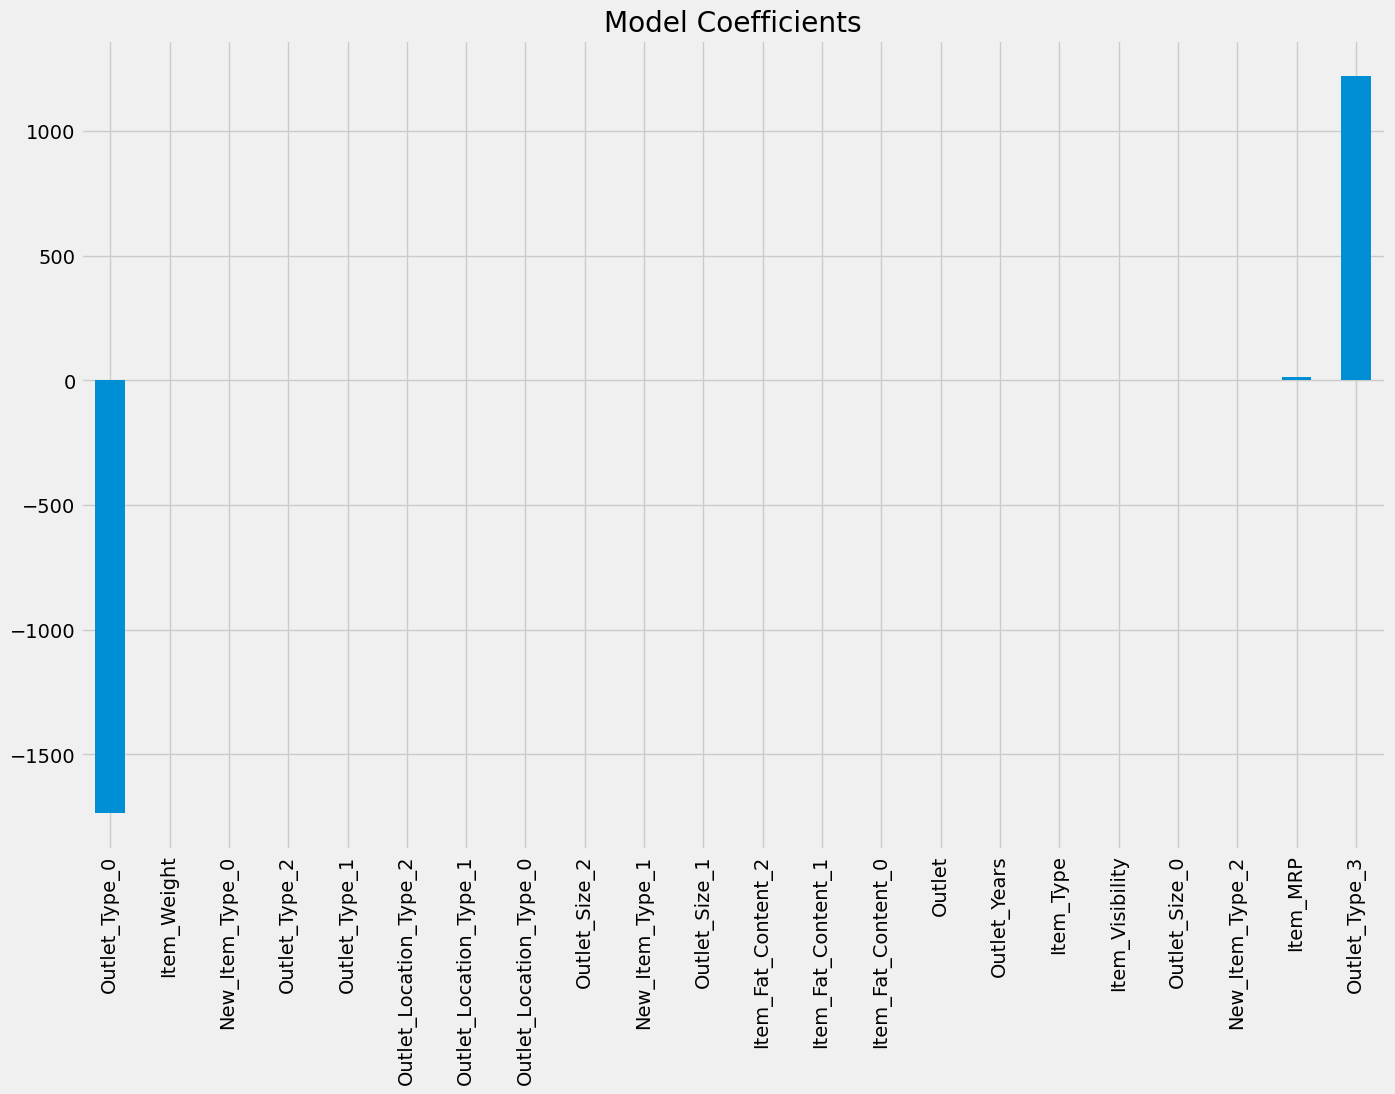

In [54]:
model = Lasso(normalize = True)
train(model, x_train, y_train)

_**Defining the function for the ML algorithm and fitting it with the passing dependent and independent variable, predicting the dependent variable using algorithm with independent variable. With using  <span style = 'background : green'><span style = 'color : white'> cross val score [Cross Validation] </span> </span> process getting the Model Report with cv_score using "neg_mean_squared_error" as scoring and also getting the absolute average mean of cv_score. After that using  <span style = 'background : green'><span style = 'color : white'> cross val score [Cross Validation] </span> </span> process, getting the cv_score as R2 score using default scoring parameter and also again getting the mean value of cv_score with default scoring as Average R2 score. End of the function the Accuracy for full data is actually determined using  actual R2 score founded between the dependent variable and predicted dependent variable. Atlast getting the feature importance of all the columns and plotting the graph using feature importance of algorithm to show impact of the each column**_

In [55]:
def train(model, x, y):
    model.fit(x, y)
    pred = model.predict(x)
    cv_score = cross_val_score(model,x,y,scoring = 'neg_mean_squared_error', cv = 10)
    print('Model Report : \n')
    print('Scoring - neg_mean_squared_error')
    print(cv_score,'\n')
    cv_score = np.abs(np.mean(cv_score))
    print('Absolute Average of neg_mean_squared_error : ',cv_score)
    cv_score = cross_val_score(model, x, y, cv = 10)
    print()
    print('R2 Score')
    print(cv_score,'\n')
    cv_score = np.mean(cv_score)
    print('Average R2 Score : ',cv_score,'\n')
    print('Accuracy for Full Data :')
    print('R2 Score : ',r2_score(y,pred),'\n')
    coef = pd.Series(model.feature_importances_, x.columns).sort_values(ascending=False)
    coef.plot(kind='bar', title="Feature Importance")
    plt.show()

_**Fitting the <span style ='color:green'> Decision Tree Regressor </span> algorithm to the model and passing it to the defined function with train dependent and train independent variable and getting the output for the defined function**_

Model Report : 

Scoring - neg_mean_squared_error
[-2623632.32874612 -2352017.10861737 -2496312.31562113 -2252146.99263791
 -2408183.37992486 -2734519.39220598 -2329370.70210725 -2301118.56959515
 -2003359.72762407 -2370728.69282594] 

Absolute Average of neg_mean_squared_error :  2387138.9209905793

R2 Score
[0.11461546 0.16324701 0.19365505 0.307279   0.25751761 0.01748966
 0.18001307 0.14121656 0.28822959 0.19429159] 

Average R2 Score :  0.1857554585970127 

Accuracy for Full Data :
R2 Score :  1.0 



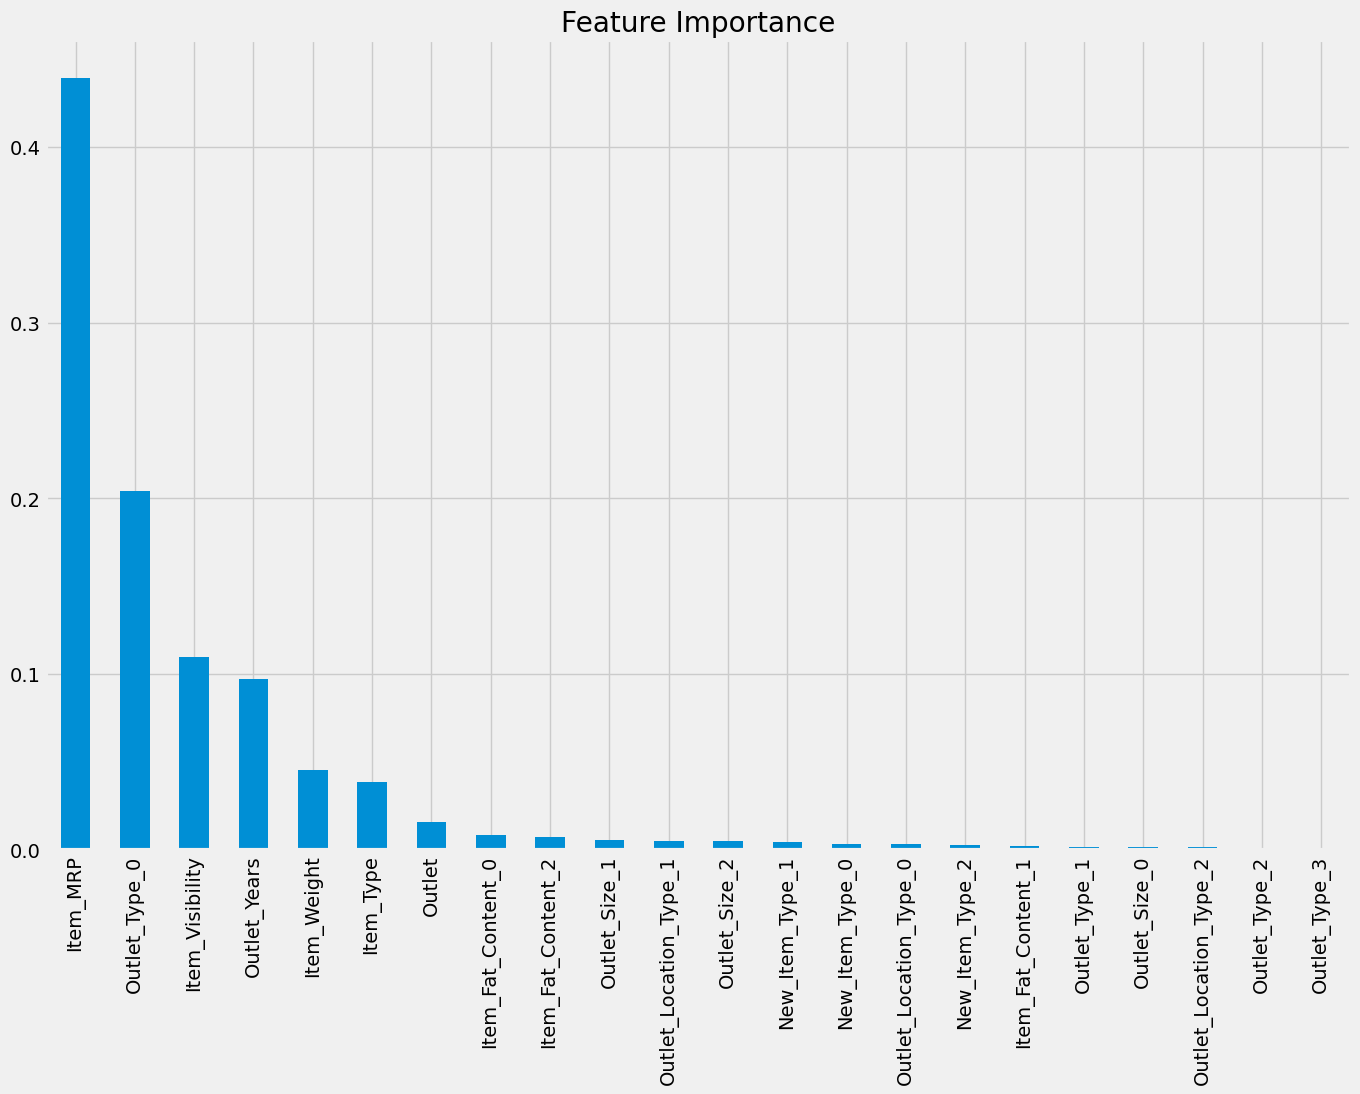

In [56]:
model = DecisionTreeRegressor()
train(model, x_train, y_train)

_**Fitting the <span style ='color:green'> Random Forest Regressor </span> algorithm to the model and passing it to the defined function with train dependent and train independent variable and getting the output for the defined function**_

Model Report : 

Scoring - neg_mean_squared_error
[-1264270.49292733 -1334711.13153974 -1270528.40593905 -1334360.53356951
 -1235921.82343569 -1446557.70179642 -1179419.0906752  -1461810.48515835
 -1111844.75533706 -1381195.9820495 ] 

Absolute Average of neg_mean_squared_error :  1302062.0402427851

R2 Score
[0.55841225 0.5362617  0.58238439 0.5829919  0.6204502  0.46580757
 0.58834996 0.4777993  0.59091409 0.50041001] 

Average R2 Score :  0.5503781368669042 

Accuracy for Full Data :
R2 Score :  0.9368055395319906 



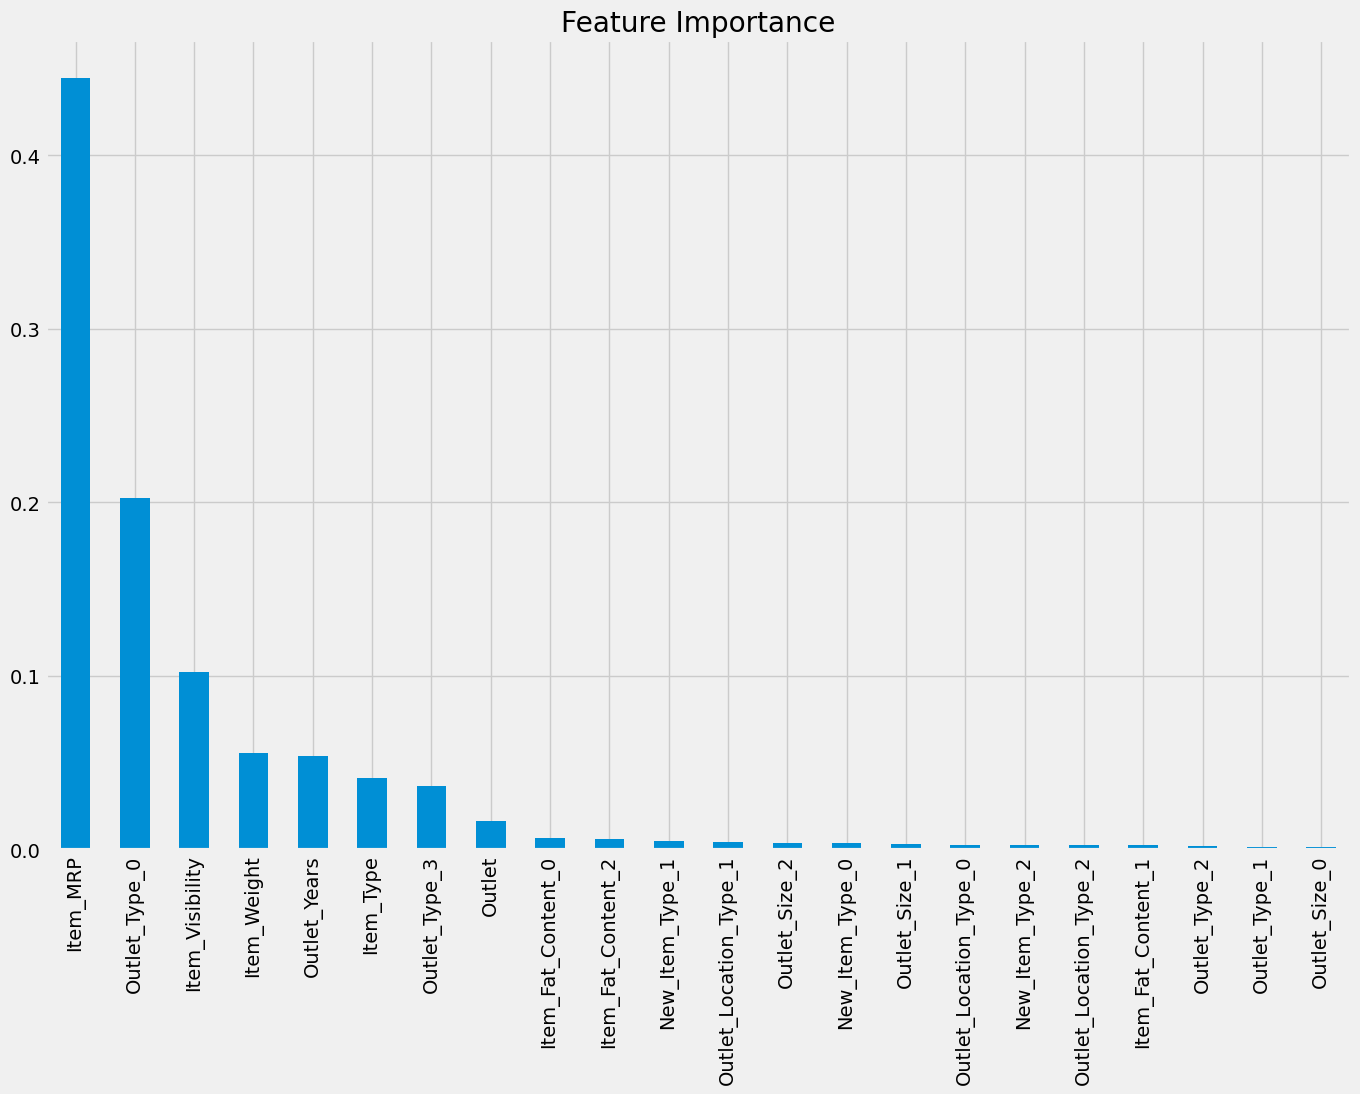

In [57]:
model = RandomForestRegressor()
train(model, x_train, y_train)

_**Fitting the <span style ='color:green'> Extra Trees Regressor </span> algorithm to the model and passing it to the defined function with train dependent and train independent variable and getting the output for the defined function**_

Model Report : 

Scoring - neg_mean_squared_error
[-1387527.50039993 -1399784.22938903 -1400999.73030788 -1435772.78152411
 -1325152.83531024 -1516767.82952797 -1249546.04026013 -1494049.68352577
 -1196277.42616153 -1390363.39762696] 

Absolute Average of neg_mean_squared_error :  1379624.1454033547

R2 Score
[0.50863825 0.51419132 0.53193984 0.56552101 0.59048521 0.43817657
 0.56510502 0.45753396 0.56228239 0.48807603] 

Average R2 Score :  0.5221949589442649 

Accuracy for Full Data :
R2 Score :  0.9999999212381735 



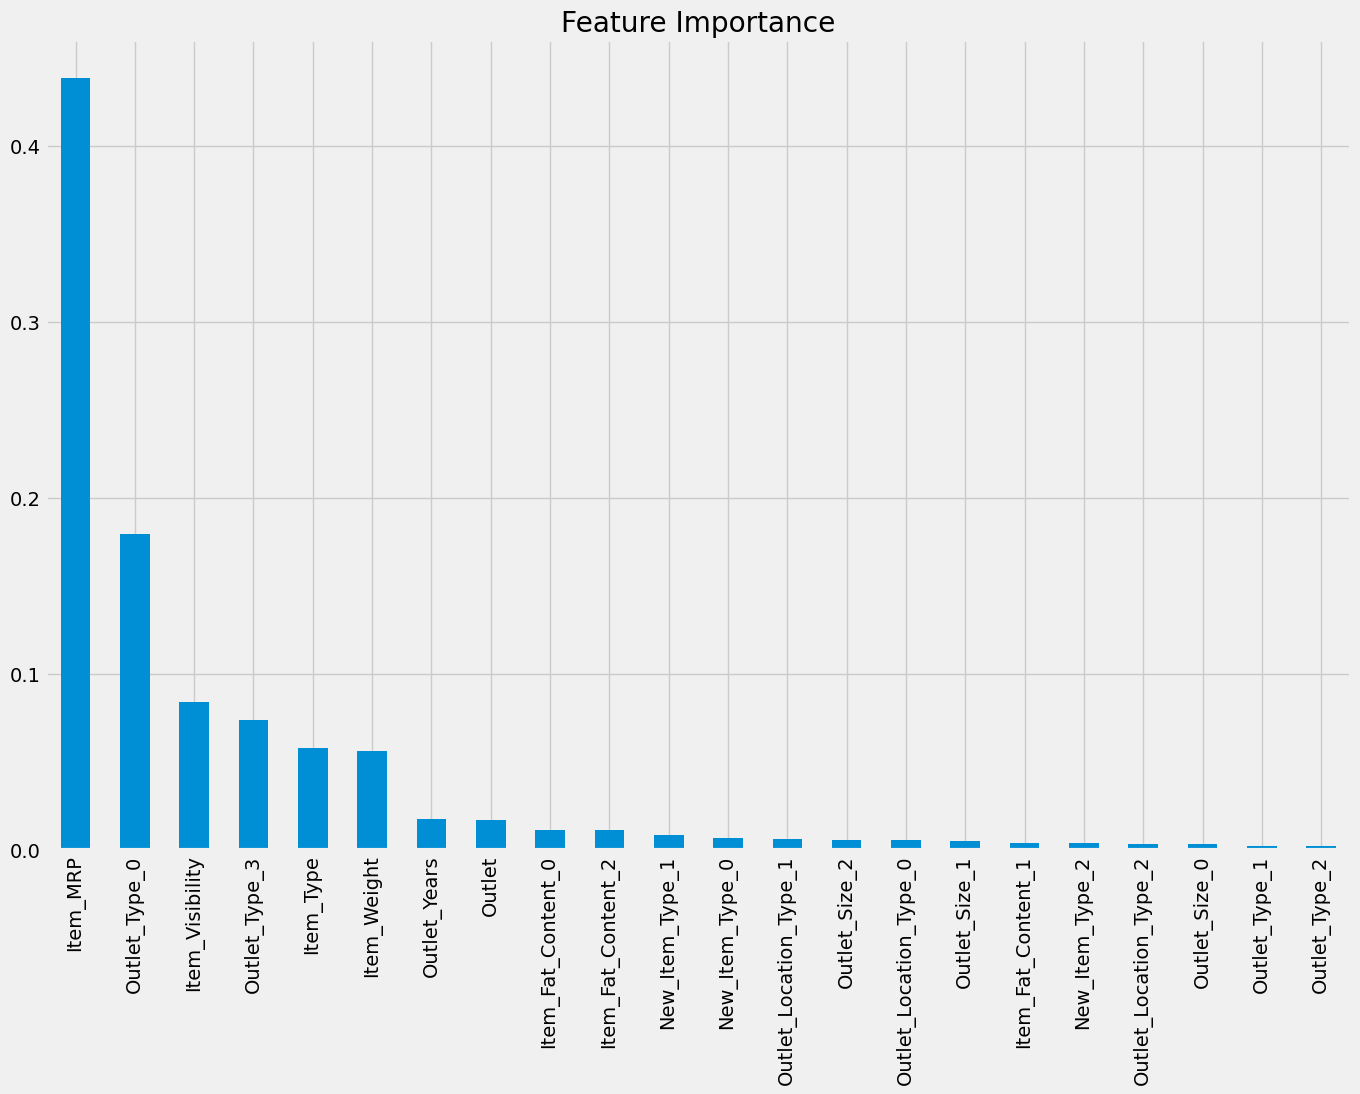

In [58]:
model = ExtraTreesRegressor()
train(model, x_train, y_train)

_**Fitting the <span style ='color:green'> LGBM Regressor </span> algorithm to the model and passing it to the defined function with train dependent and train independent variable and getting the output for the defined function**_

Model Report : 

Scoring - neg_mean_squared_error
[-1225021.83167154 -1240413.23365474 -1244228.12250563 -1283278.55009791
 -1149795.48776179 -1368829.19888885 -1154552.08706992 -1353333.29913505
 -1061644.98310814 -1351233.56181511] 

Absolute Average of neg_mean_squared_error :  1243233.0355708674

R2 Score
[0.57203162 0.57272759 0.59023134 0.60289474 0.64073314 0.49682687
 0.59808907 0.51255184 0.60758914 0.51422663] 

Average R2 Score :  0.5707901985310498 

Accuracy for Full Data :
R2 Score :  0.742360050431971 



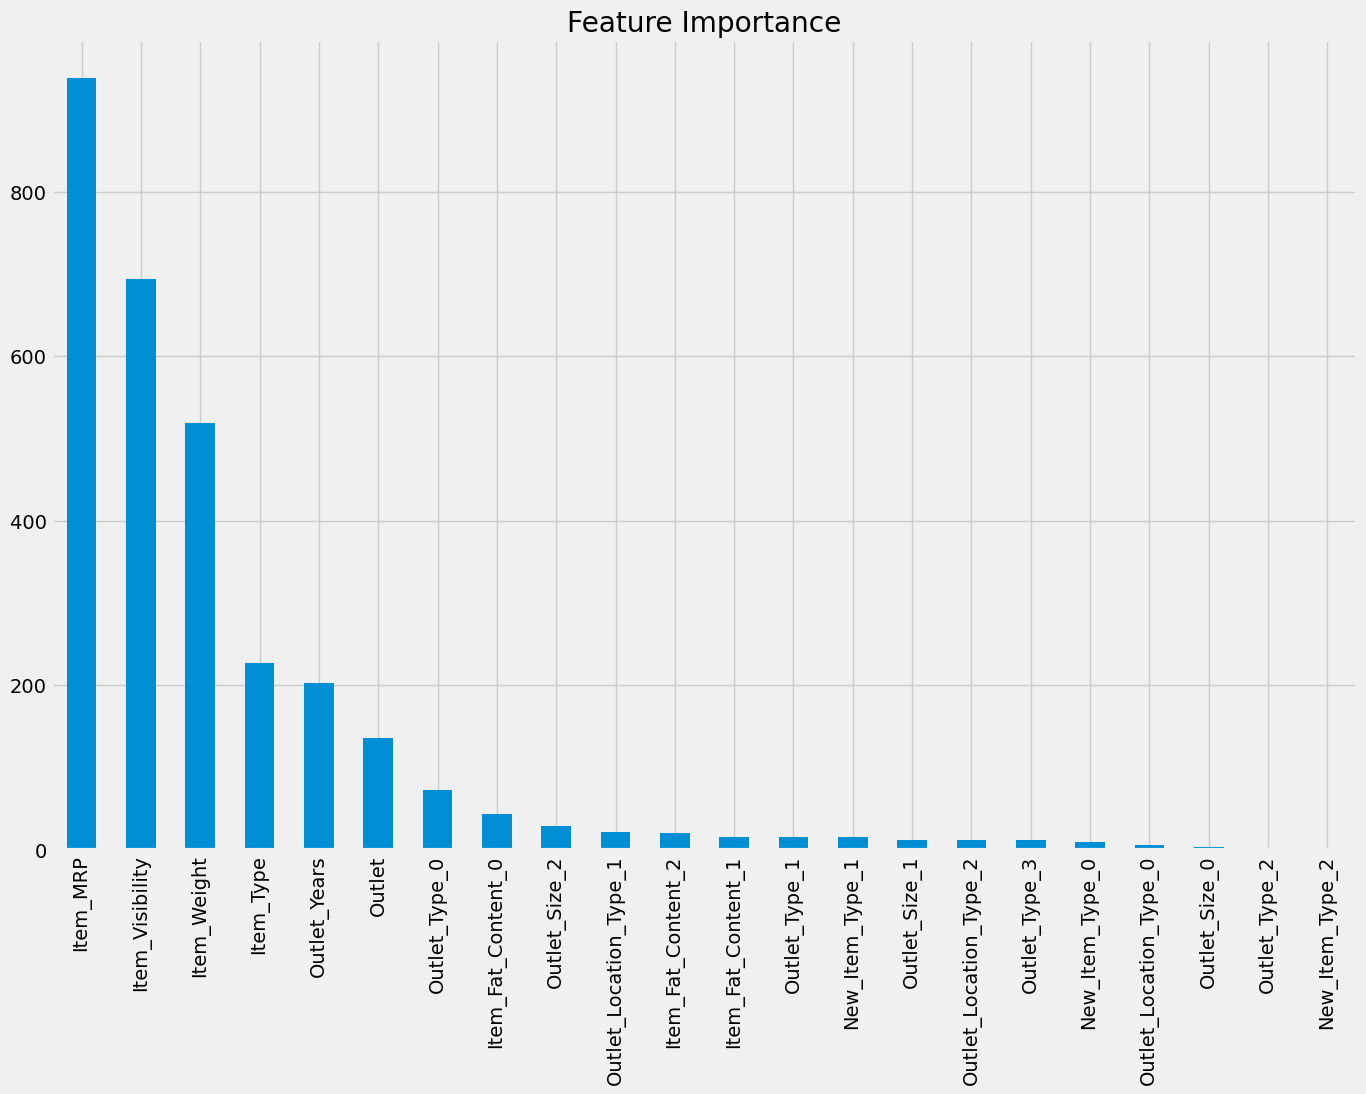

In [59]:
model = LGBMRegressor()
train(model, x_train, y_train)

_**Fitting the <span style ='color:green'> XGB Regressor </span> algorithm to the model and passing it to the defined function with train dependent and train independent variable and getting the output for the defined function**_

Model Report : 

Scoring - neg_mean_squared_error
[-1302021.34802141 -1347293.36539867 -1302574.5294862  -1423142.2751991
 -1253674.69436762 -1519804.3870573  -1233491.69882174 -1508361.77560653
 -1202318.65105563 -1470911.59818954] 

Absolute Average of neg_mean_squared_error :  1356359.432320376

R2 Score
[0.5451314  0.53591169 0.57101579 0.55961449 0.60827488 0.44132933
 0.57060942 0.45671316 0.55559259 0.47120195] 

Average R2 Score :  0.5315394686500091 

Accuracy for Full Data :
R2 Score :  0.8631529181826877 



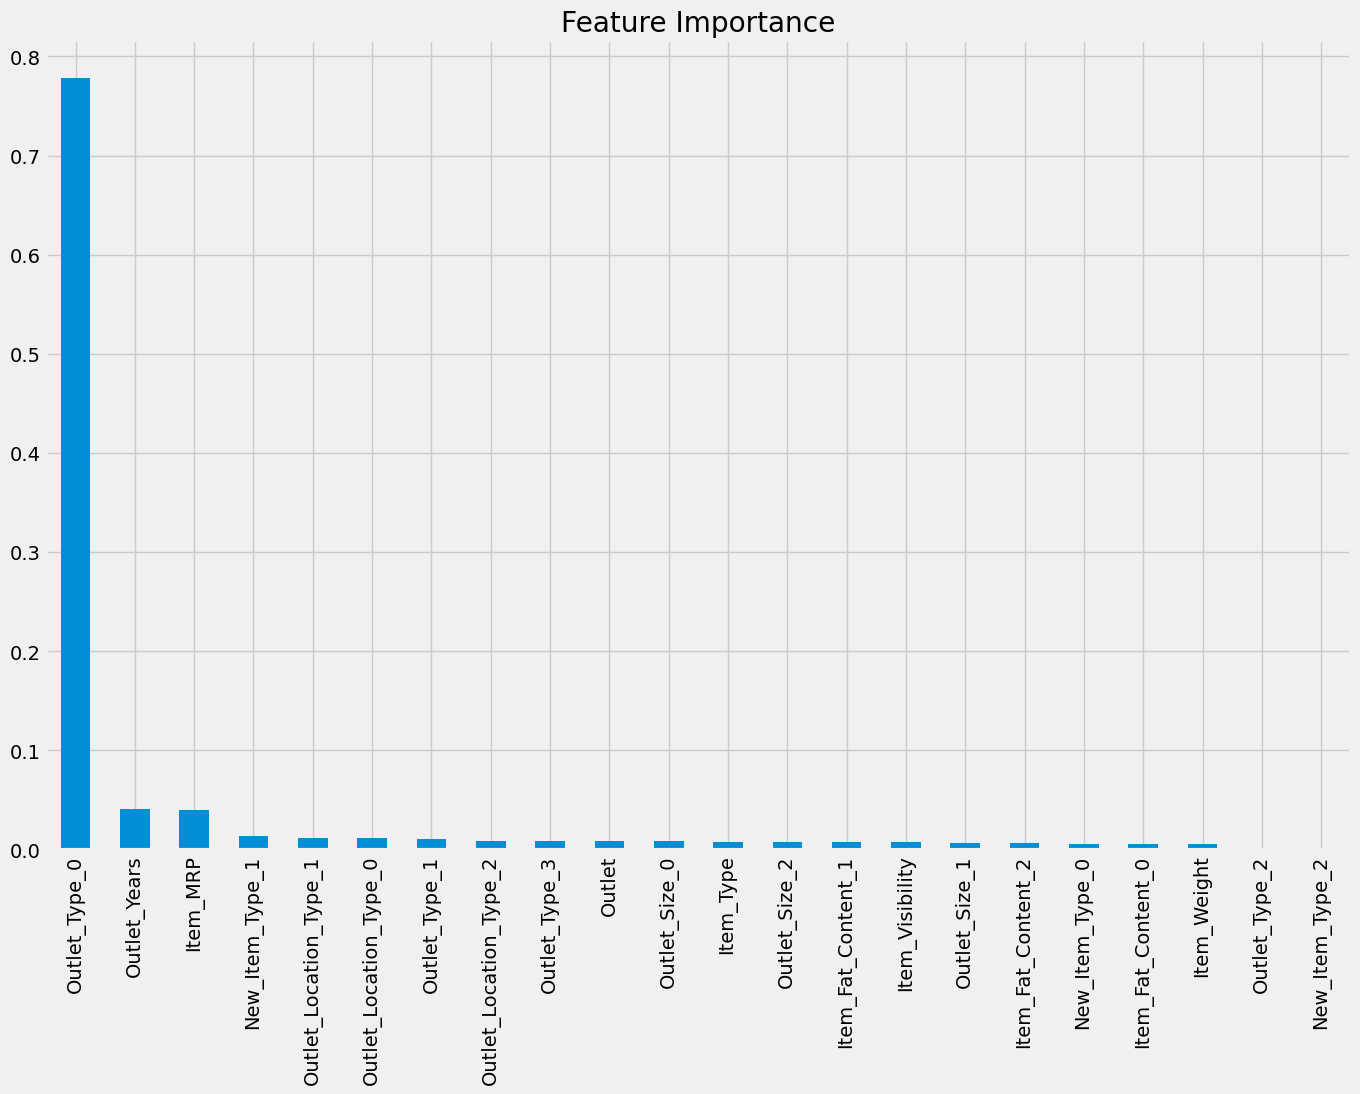

In [60]:
model = XGBRegressor()
train(model, x_train, y_train)

_**Fitting the <span style ='color:green'> Cat Boost Regressor </span> algorithm to the model and passing it to the defined function with train dependent and train independent variable and getting the output for the defined function**_

Model Report : 

Scoring - neg_mean_squared_error
[-1204342.95001023 -1258326.80109096 -1236189.83533822 -1305120.10336832
 -1133897.68095895 -1358844.46809349 -1125484.0315177  -1338789.18295122
 -1056983.85106778 -1321537.20330976] 

Absolute Average of neg_mean_squared_error :  1233951.6107706637

R2 Score
[0.57925591 0.56655709 0.59287863 0.59613596 0.64570059 0.5004972
 0.60820795 0.51779039 0.60931201 0.52490258] 

Average R2 Score :  0.5741238307892427 

Accuracy for Full Data :
R2 Score :  0.7748063677888094 



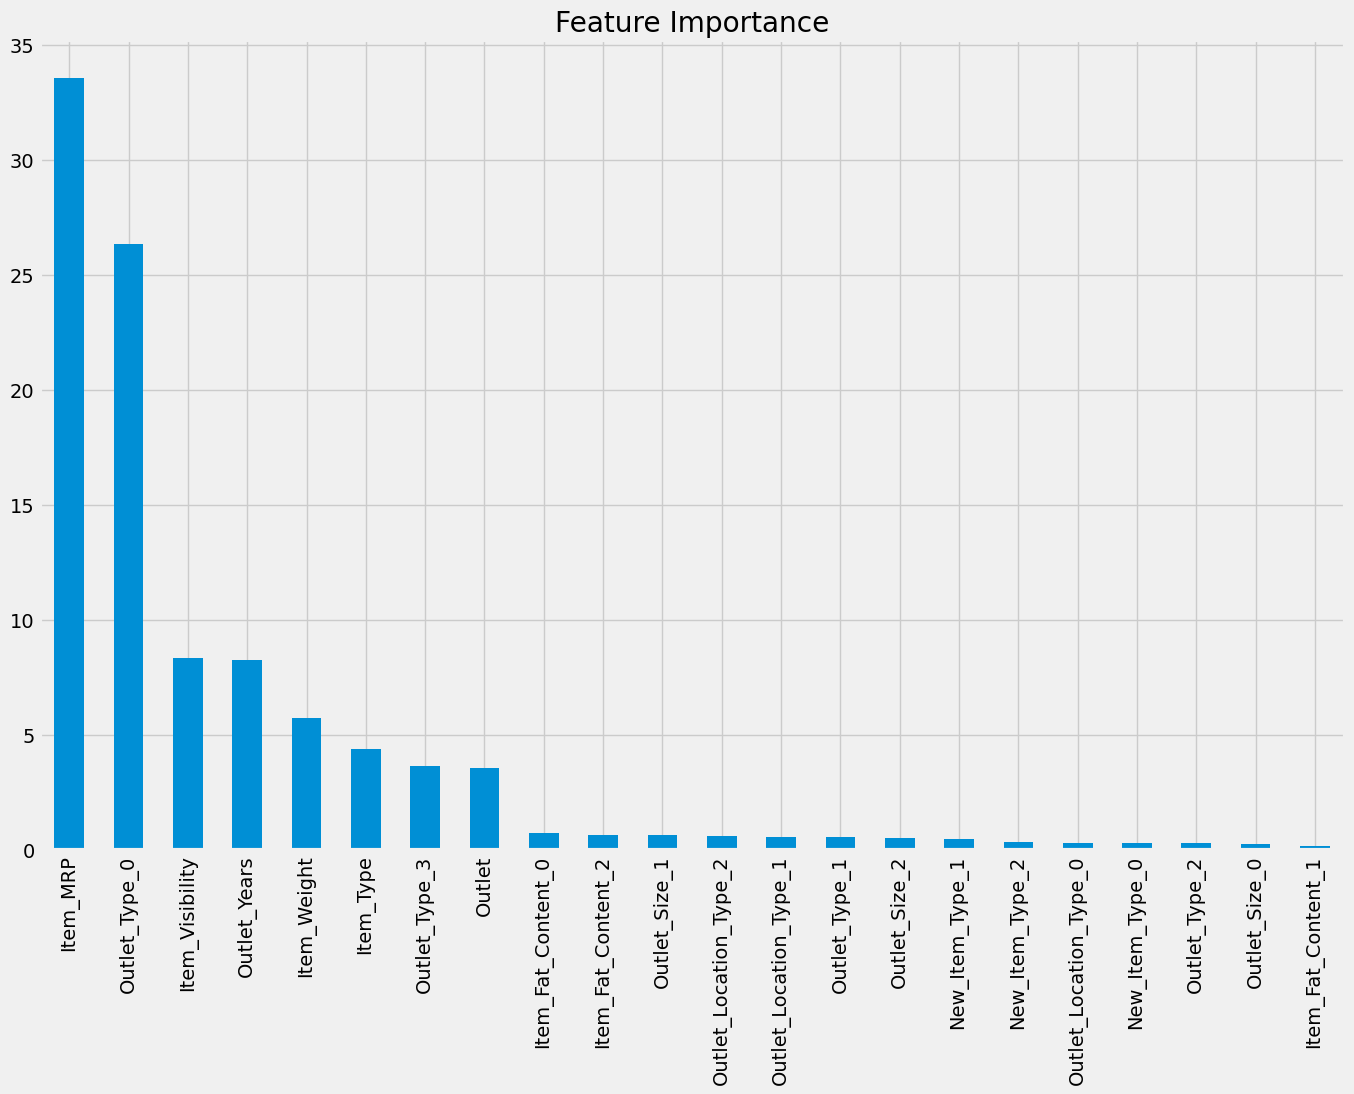

In [61]:
model = CatBoostRegressor(verbose = 0)
train(model, x_train, y_train)

_**Passing some of the list of parameters for the <span style ='color:green'> Random Forest Regressor </span> Model to run with Randomized Search CV Algorithm**_

In [62]:
random_grid = {
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(5, 30, num = 6)],
               'min_samples_split':[2, 5, 10, 15, 100],
               'min_samples_leaf': [1, 2, 5, 10]
}

_**Fitting The <span style ='color:green'>Random Forest Regressor</span> Model with the above mentioned parameters in the RandomizedSearchCV Algorithm and displaying the Best Parameters, Best Score and R2 Score between test dependent variable and predicted dependent variable**_

In [63]:
RF = RandomForestRegressor()
RF = RandomizedSearchCV(estimator = RF, param_distributions = random_grid, scoring = 'neg_mean_squared_error', n_iter =10,
                       verbose = 0, cv =10, random_state = 10, n_jobs = 1)
RF.fit(x_train, y_train)
print('Best Params : ',RF.best_params_,'\n')
print('Best Score : ',RF.best_score_,'\n')
prediction = RF.predict(x_test)
print('R2 Score : ',r2_score(y_test,prediction))

Best Params :  {'min_samples_split': 100, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 20} 

Best Score :  -1182568.4907000675 

R2 Score :  0.5894944164756013


_**Visualizing the data distribution of the dependent test variable , predicted dependent variable of the Random Forest Regressor Model against the density distribution using Seaborn Distplot**_

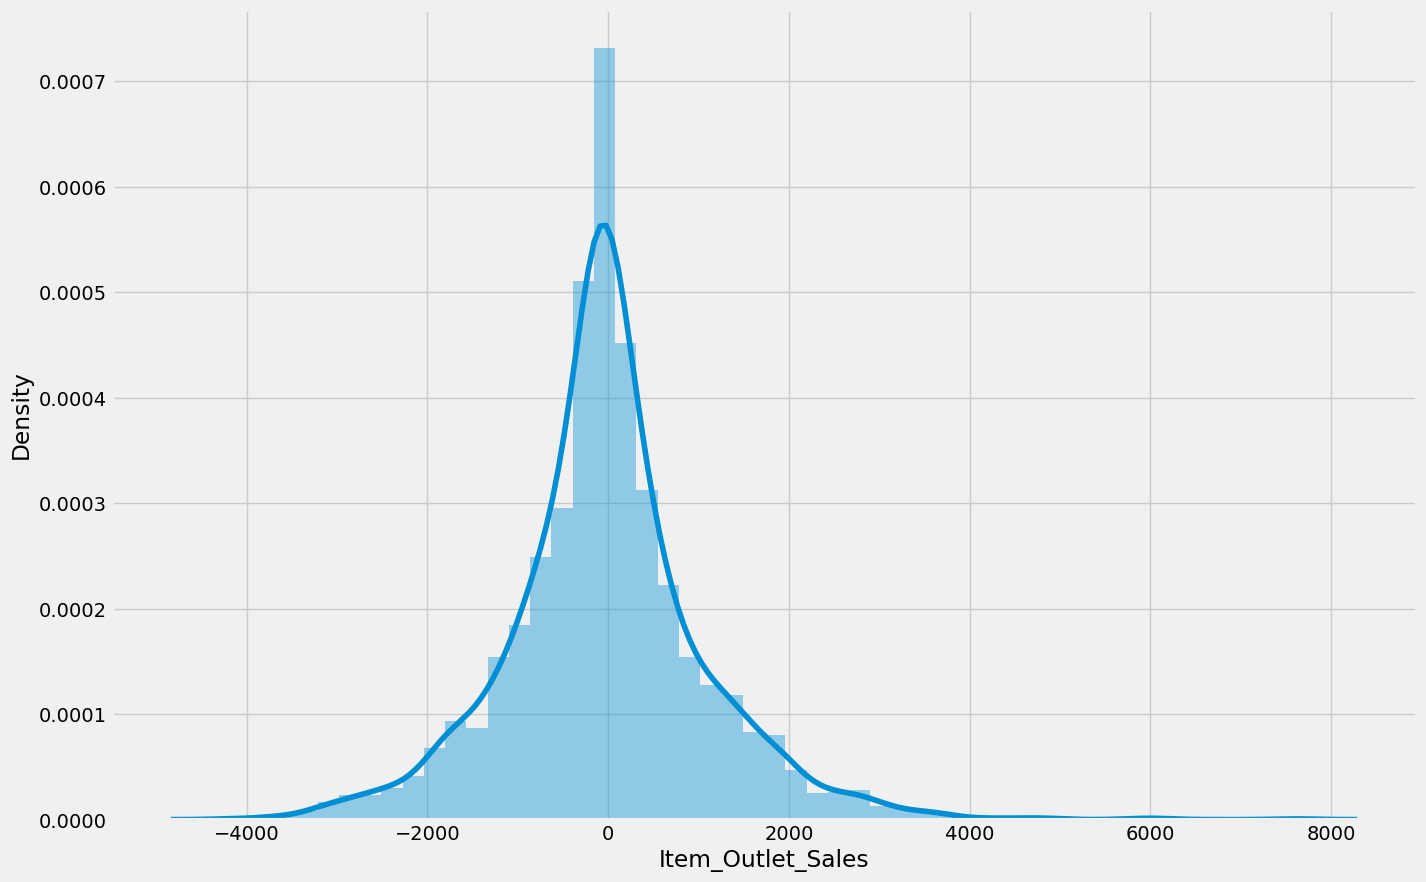

In [64]:
sns.distplot(y_test-prediction)
plt.show()

_**Passing some of the list of parameters for the <span style ='color:green'> LGBM Regressor </span> Model to run with Randomized Search CV Algorithm**_

In [65]:
params = {
    "learning_rate": uniform(0.03, 0.3), 
    "max_depth": randint(2, 6),
    "n_estimators": randint(100, 150), 
    "subsample": uniform(0.6, 0.4)
}

_**Fitting The <span style ='color:green'>LGBM Regressor</span> Model with the above mentioned parameters in the RandomizedSearchCV Algorithm and displaying the Best Parameters, Best Score and R2 Score between test dependent variable and predicted dependent variable**_

In [66]:
lgb = LGBMRegressor()
lgb = RandomizedSearchCV(estimator = lgb, param_distributions = params, cv = 10, n_iter = 10, verbose = 0,
                        scoring = 'neg_mean_squared_error', n_jobs = 1, random_state = 10)
lgb.fit(x_train,y_train)
print('Best Params : ',lgb.best_params_,'\n')
print('Best Score : ',lgb.best_score_,'\n')
prediction = lgb.predict(x_test)
print('R2 Score : ',r2_score(y_test,prediction))

Best Params :  {'learning_rate': 0.08941885942788719, 'max_depth': 2, 'n_estimators': 109, 'subsample': 0.6676443346250142} 

Best Score :  -1159780.859143458 

R2 Score :  0.595095495351745


_**Visualizing the data distribution of the dependent test variable , predicted dependent variable of the LGBM Regressor Model against the density distribution using Seaborn Distplot**_

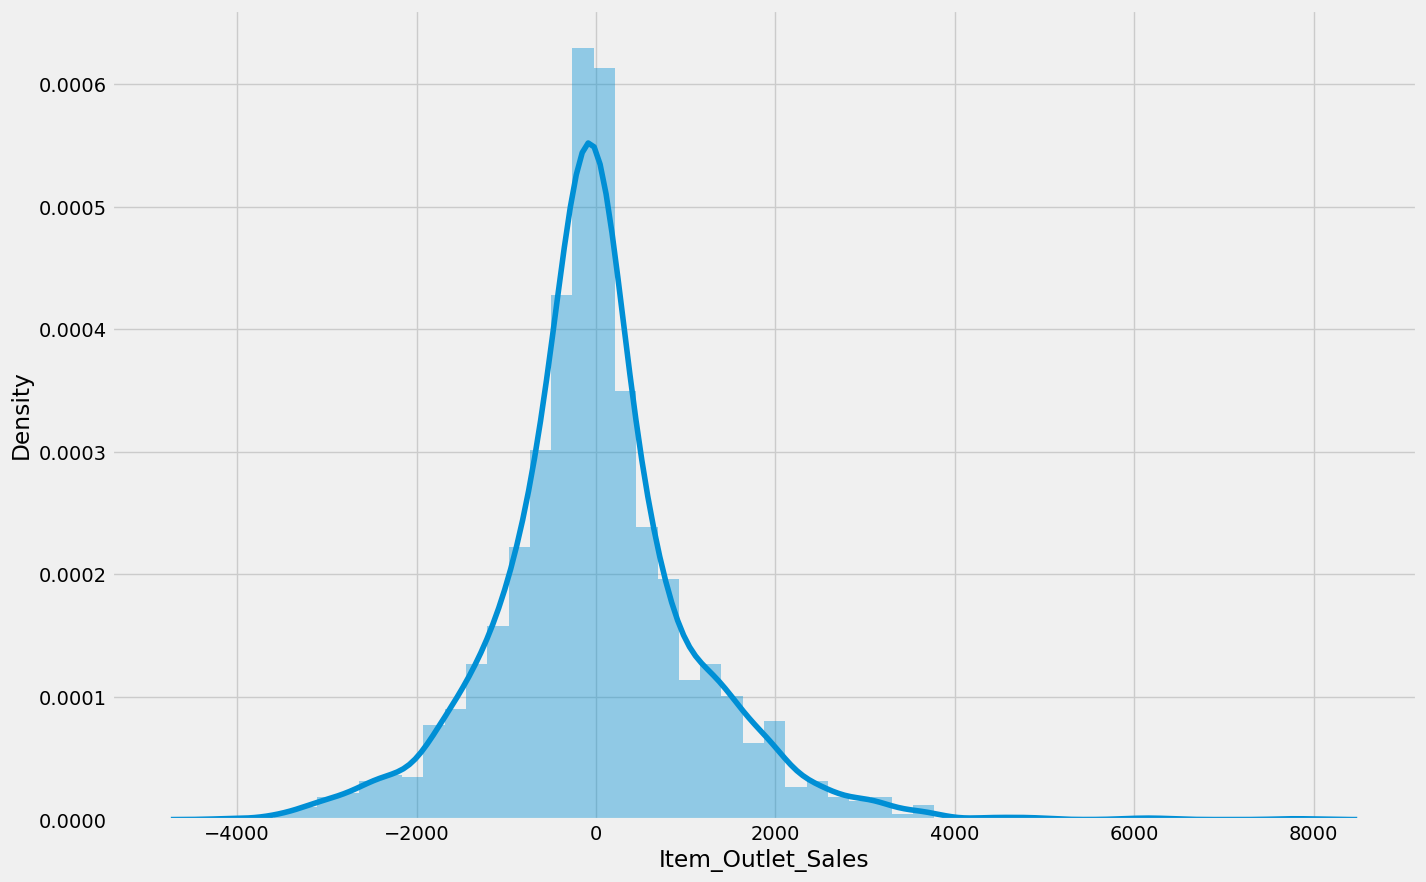

In [67]:
sns.distplot(y_test-prediction)
plt.show()

_**Passing some of the list of parameters for the <span style ='color:green'> XGB Regressor </span> Model to run with Randomized Search CV Algorithm**_

In [68]:
params = {
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), 
    "max_depth": randint(2, 6),
    "n_estimators": randint(100, 150), 
    "subsample": uniform(0.6, 0.4)
}

_**Fitting The <span style ='color:green'>XGB Regressor</span> Model with the above mentioned parameters in the RandomizedSearchCV Algorithm and displaying the Best Parameters, Best Score and R2 Score between test dependent variable and predicted dependent variable**_

In [69]:
xgb = XGBRegressor()
xgb = RandomizedSearchCV(estimator = xgb, param_distributions = params, cv = 10, n_iter = 10, verbose = 0,
                        scoring = 'neg_mean_squared_error', n_jobs = 1, random_state = 10)
xgb.fit(x_train, y_train)
print('Best Params : ',xgb.best_params_,'\n')
print('Best Score : ',xgb.best_score_,'\n')
prediction = xgb.predict(x_test)
print('R2 Score : ',r2_score(y_test,prediction))

Best Params :  {'gamma': 0.385660321633373, 'learning_rate': 0.03622558480782045, 'max_depth': 2, 'n_estimators': 149, 'subsample': 0.8995215530154448} 

Best Score :  -1167781.8669058667 

R2 Score :  0.594657938463726


_**Visualizing the data distribution of the dependent test variable , predicted dependent variable of the XGB Regressor Model against the density distribution using Seaborn Distplot**_

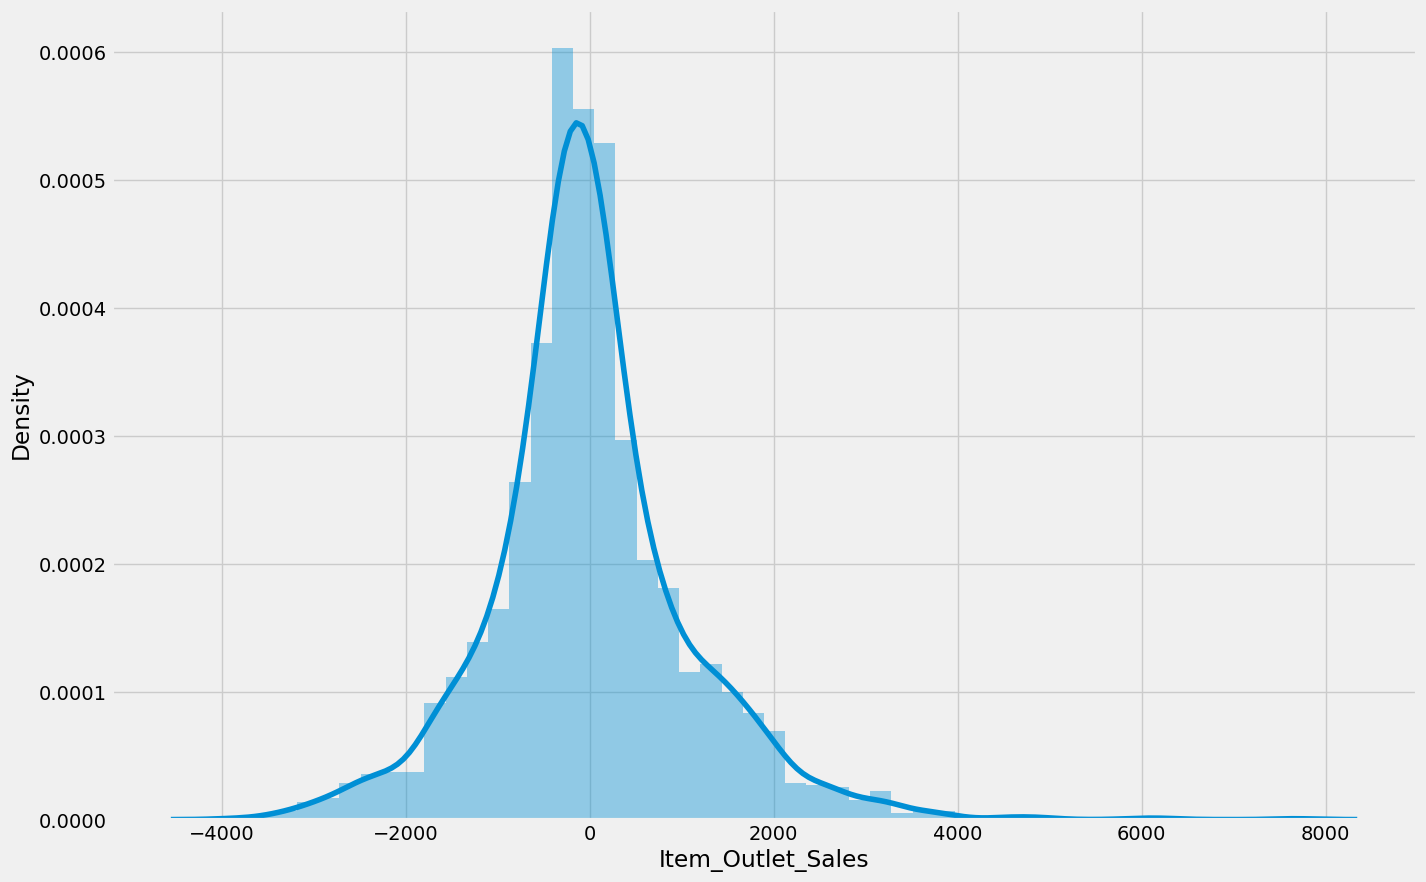

In [70]:
sns.distplot(y_test-prediction)
plt.show()

_**Passing some of the list of parameters for the <span style ='color:green'> CatBoost Regressor </span> Model to run with Randomized Search CV Algorithm**_

In [71]:
params = {
    "learning_rate": uniform(0.03, 0.3), 
    "max_depth": randint(2, 6),
    "n_estimators": randint(100, 150), 
    "subsample": uniform(0.6, 0.4)
}

_**Fitting The <span style ='color:green'>CatBoost Regressor</span> Model with the above mentioned parameters in the RandomizedSearchCV Algorithm and displaying the Best Parameters, Best Score and R2 Score between test dependent variable and predicted dependent variable**_

In [72]:
cat = CatBoostRegressor(verbose = 0)
cat = RandomizedSearchCV(estimator = cat, param_distributions = params, cv = 10, n_iter = 10, verbose = 0,
                        scoring = 'neg_mean_squared_error', n_jobs = 1, random_state = 10)
cat.fit(x_train,y_train)
print('Best Params : ',cat.best_params_,'\n')
print('Best Score : ',cat.best_score_,'\n')
prediction = cat.predict(x_test)
print('R2 Score : ',r2_score(y_test,prediction))

Best Params :  {'learning_rate': 0.08941885942788719, 'max_depth': 2, 'n_estimators': 109, 'subsample': 0.6676443346250142} 

Best Score :  -1162841.1046650507 

R2 Score :  0.5976757966600554


_**Visualizing the data distribution of the dependent test variable , predicted dependent variable of the CatBoost Regressor Model against the density distribution using Seaborn Distplot**_

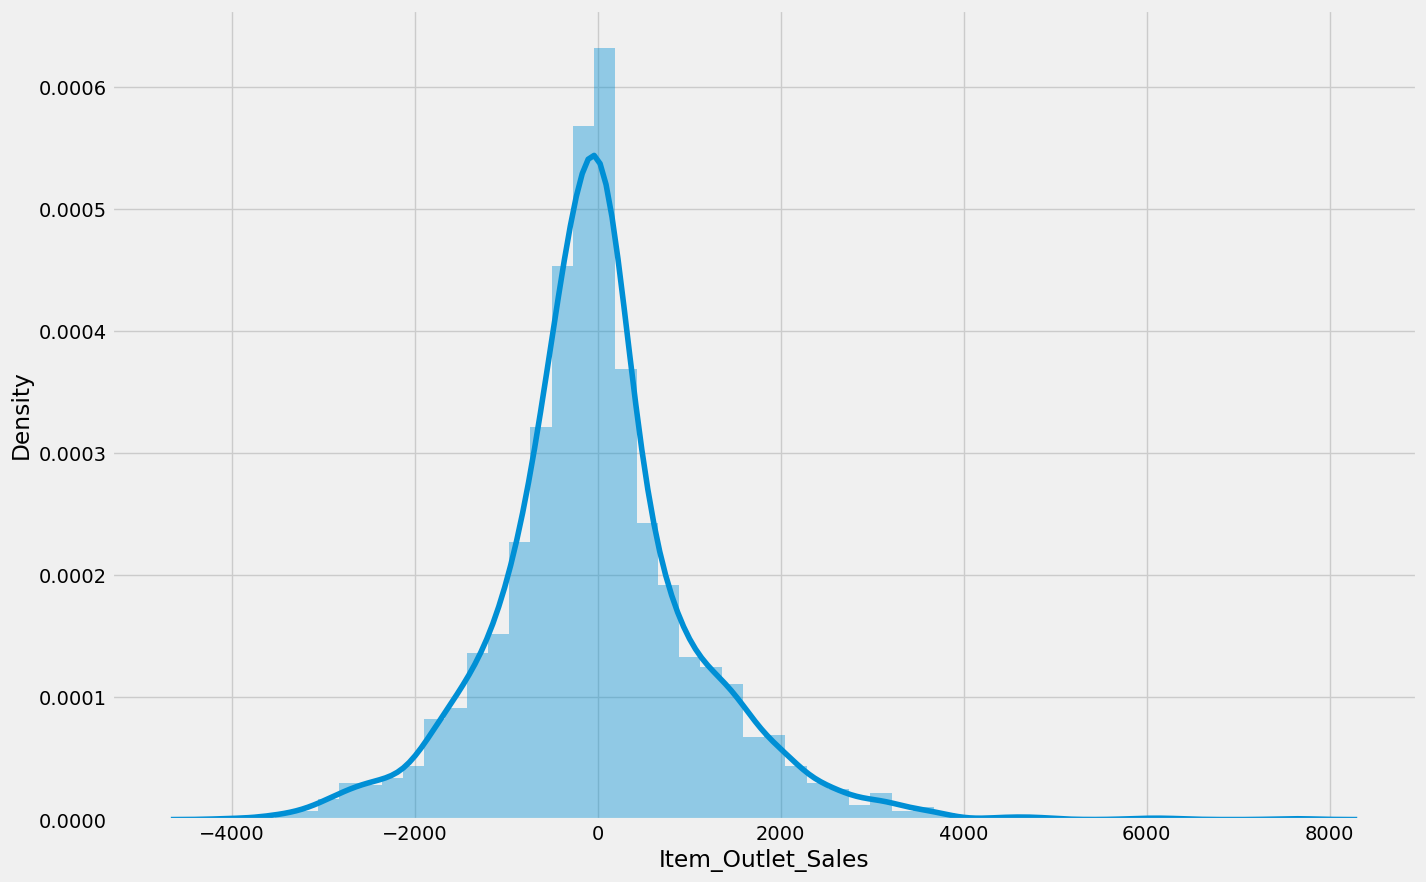

In [73]:
sns.distplot(y_test-prediction)
plt.show()

_**Fitting The <span style ='color:green'>CatBoost Regressor</span> Model with the best params got from the Randomized SearchCV and predicting the test dependent data to verify the r2 score with the r2 score got from Randomized SearchCV**_

In [74]:
cat = CatBoostRegressor(learning_rate = 0.08941885942788719, max_depth = 2, n_estimators = 109, 
                        subsample = 0.6676443346250142, verbose = 0)
cat.fit(x_train,y_train)
predictions = cat.predict(x_test)
print('R2 score : ',r2_score(y_test,predictions))

R2 score :  0.5976757966600554


## Model Testing

_**Create the pickle file of the model with the highest r2 score with the name Model**_

In [75]:
pickle.dump(cat,open('Model.pkl','wb'))

_**Loading the pickle file and predicting the dependent variable for the whole data and getting the r2 score between the predicted dependent variable and dependent variable**_

In [76]:
model = pickle.load(open('Model.pkl','rb'))
fpred = model.predict(x)
print('R2 Score of Full Data : ',r2_score(y,fpred))

R2 Score of Full Data :  0.6053656226149531
